In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xgboost
!pip install optuna
!pip install lightgbm
!pip install catboost

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 210 kB 45.8 MB/s 
     |████████████████████████████████| 80 kB 9.0 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 149 kB 47.7 MB/s 
     |████████████████████████████████| 112 kB 45.8 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=344cfa7e4bd357bb357045456e73b4e986754e2538cb0ba5551a3b9275734921
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [3]:
# データ操作
import numpy as np
import pandas as pd
from pandas import plotting 

# データ可視化
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#日付の扱い
import datetime
from datetime import timedelta

#正規化とか
import scipy.stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#主成分分析器
from sklearn.decomposition import PCA 

# 交差検証
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_validate

#誤差確認
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#重回帰
from sklearn.linear_model import LinearRegression

#ランダムフォレスト
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor

#DNN
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline

#XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

#LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

#CatBoost
from catboost import CatBoost
from catboost import Pool
from catboost import CatBoostClassifier

#パラメータチューニング
import optuna

#警告無視
import warnings
warnings.filterwarnings('ignore')

In [4]:
train=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIGNATE/bank_maketing/train.csv")
test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIGNATE/bank_maketing/test.csv")

In [5]:
train.shape

(27128, 18)

In [6]:
train.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [7]:
train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown,1
1,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown,1
2,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure,1
3,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown,1
4,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success,1


#前処理

In [8]:
#欠損値処理のために一旦統合
#TrainFlagという列を新たに作り、訓練データにはTrue、テストデータにはFalseとしておく。
train["TrainFlag"] = True
test["TrainFlag"] = False

#訓練データとテストデータを結合する
alldata = train.append(test)

#目的変数を先頭コラムに
cols=alldata.columns.tolist()
cols=cols[-2:]+cols[:-2]

alldata =  alldata[cols] 
alldata

,y,TrainFlag,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1.0,True,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,939,1,-1,0,unknown
1,1.0,True,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,172,10,-1,0,unknown
2,1.0,True,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,567,1,595,2,failure
3,1.0,True,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,423,1,-1,0,unknown
4,1.0,True,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,502,1,9,2,success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,NaN,False,18079,30,management,married,tertiary,no,32,yes,no,unknown,6,may,122,3,-1,0,unknown
18079,NaN,False,18080,35,management,married,tertiary,no,1557,yes,yes,cellular,5,feb,225,1,268,1,failure
18080,NaN,False,18081,33,housemaid,married,primary,no,1713,yes,no,unknown,8,may,22,1,-1,0,unknown
18081,NaN,False,18082,37,blue-collar,married,secondary,no,-251,yes,no,cellular,12,may,146,3,370,1,failure


In [9]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45211 entries, 0 to 18082
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   y          27128 non-null  float64
 1   TrainFlag  45211 non-null  bool   
 2   id         45211 non-null  int64  
 3   age        45211 non-null  int64  
 4   job        45211 non-null  object 
 5   marital    45211 non-null  object 
 6   education  45211 non-null  object 
 7   default    45211 non-null  object 
 8   balance    45211 non-null  int64  
 9   housing    45211 non-null  object 
 10  loan       45211 non-null  object 
 11  contact    45211 non-null  object 
 12  day        45211 non-null  int64  
 13  month      45211 non-null  object 
 14  duration   45211 non-null  int64  
 15  campaign   45211 non-null  int64  
 16  pdays      45211 non-null  int64  
 17  previous   45211 non-null  int64  
 18  poutcome   45211 non-null  object 
dtypes: bool(1), float64(1), int64(8), object(9)
me

In [10]:
#欠損地がないことが判明

In [11]:
alldata.describe()

,y,id,age,balance,day,duration,campaign,pdays,previous
count,27128.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,0.117001,11755.640043,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,0.321427,7253.072618,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,0.000000,1.000000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,0.000000,5652.000000,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,0.000000,11303.000000,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,0.000000,16954.500000,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,1.000000,27128.000000,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [12]:
alldata.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [13]:
alldata.marital.value_counts()

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

In [14]:
alldata.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [15]:
alldata.default.value_counts()

no     44396
yes      815
Name: default, dtype: int64

In [16]:
alldata.housing.value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

In [17]:
alldata.loan.value_counts()

no     37967
yes     7244
Name: loan, dtype: int64

In [18]:
alldata.contact.value_counts()

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

In [19]:
alldata.poutcome.value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

#Graph

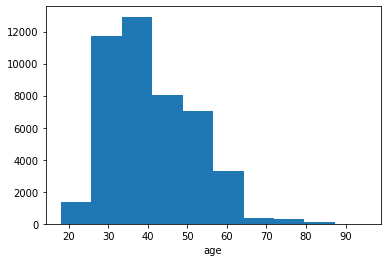

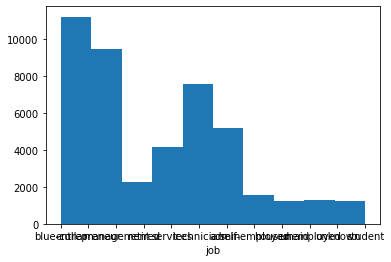

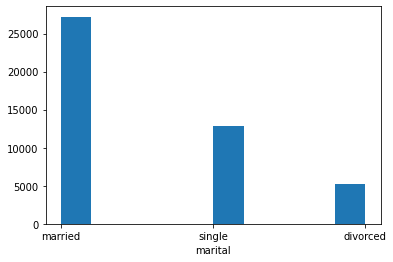

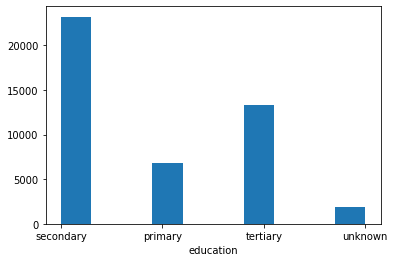

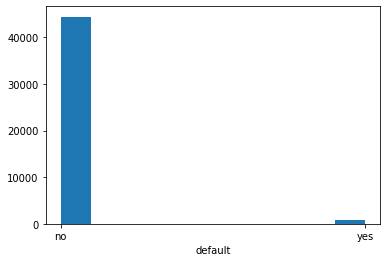

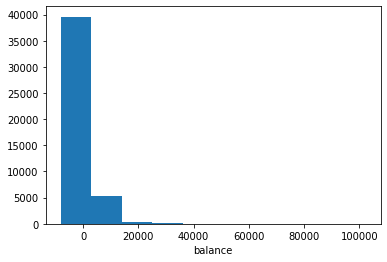

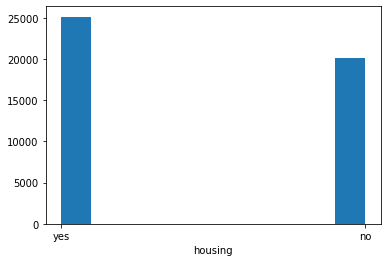

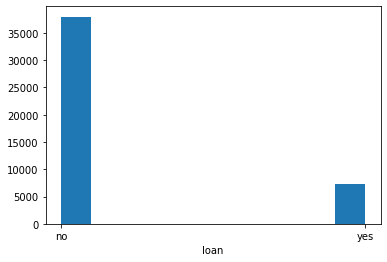

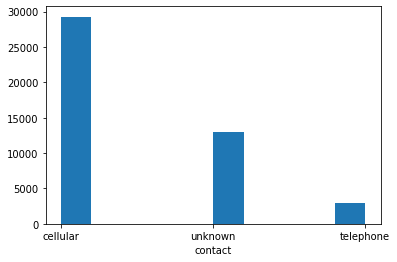

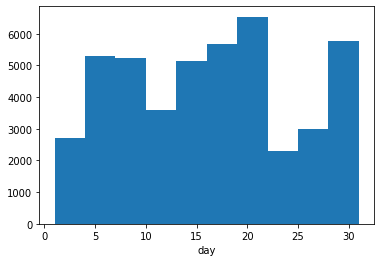

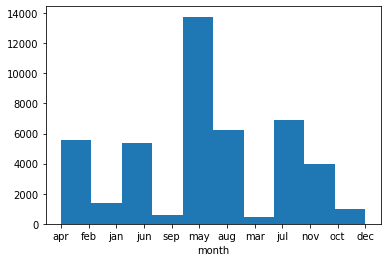

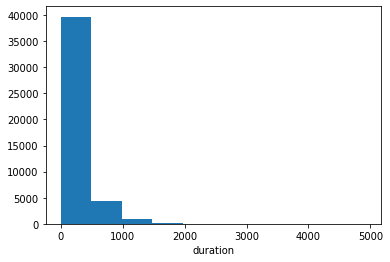

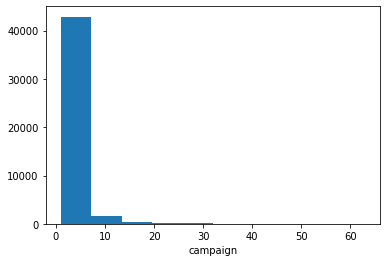

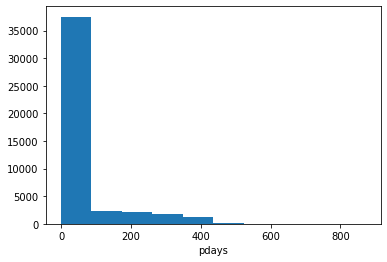

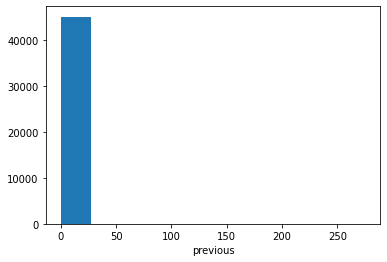

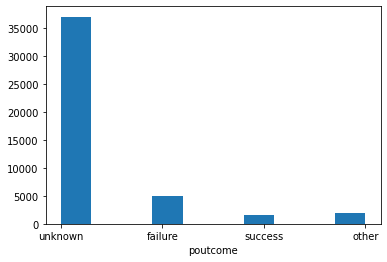

In [20]:
for i in alldata.columns[3:]:
  plt.hist(alldata[i])
  plt.xlabel(i)
  plt.show()

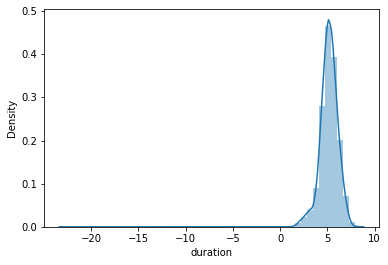

In [21]:
sns.distplot(np.log(alldata['duration']+1e-10))

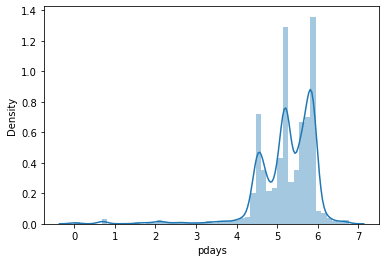

In [22]:
sns.distplot(np.log(alldata['pdays']+1e-10))

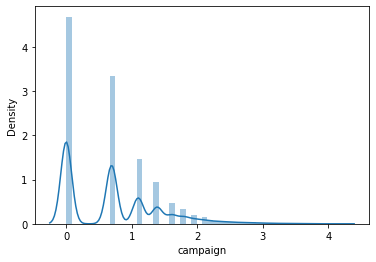

In [23]:
sns.distplot(np.log(alldata['campaign']+1e-10))

In [24]:
alldata['duration']=np.log(alldata['duration']+1e-10)
train['duration']=np.log(train['duration']+1e-10)

In [25]:
# for i in alldata.columns[3]:
#   sns.swarmplot("y",i,data=alldata)
#   plt.show()

# sns.swarmplot("y","age",data=alldata)
# plt.show()

In [26]:
# sns.swarmplot("y","balance",data=alldata)
# plt.show()

In [27]:
# sns.swarmplot("education","y",data=train)
# plt.show()

In [28]:
# sns.swarmplot("job","y",data=train)
# plt.show()

In [29]:
train.corr().style.background_gradient("summer_r")

,id,age,balance,day,duration,campaign,pdays,previous,y,TrainFlag
id,1.000000,-0.005716,-0.000484,0.002974,0.000041,0.016867,-0.004526,-0.005425,-0.003555,nan
age,-0.005716,1.000000,0.095343,-0.008518,-0.004369,-0.001340,-0.025272,0.002946,0.020892,nan
balance,-0.000484,0.095343,1.000000,0.002067,0.020514,-0.016295,0.003613,0.012483,0.045826,nan
day,0.002974,-0.008518,0.002067,1.000000,-0.060243,0.164880,-0.096889,-0.050009,-0.031058,nan
duration,0.000041,-0.004369,0.020514,-0.060243,1.000000,-0.209985,0.008214,0.000899,0.334388,nan
campaign,0.016867,-0.001340,-0.016295,0.164880,-0.209985,1.000000,-0.086220,-0.031557,-0.076118,nan
pdays,-0.004526,-0.025272,0.003613,-0.096889,0.008214,-0.086220,1.000000,0.421606,0.100930,nan
previous,-0.005425,0.002946,0.012483,-0.050009,0.000899,-0.031557,0.421606,1.000000,0.083825,nan
y,-0.003555,0.020892,0.045826,-0.031058,0.334388,-0.076118,0.100930,0.083825,1.000000,nan
TrainFlag,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [30]:
# sns.pairplot(alldata)
# plt.show()

In [31]:
alldata.head()

,y,TrainFlag,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,1.0,True,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,6.844815,1,-1,0,unknown
1,1.0,True,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,5.147494,10,-1,0,unknown
2,1.0,True,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,6.340359,1,595,2,failure
3,1.0,True,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,6.047372,1,-1,0,unknown
4,1.0,True,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,6.218600,1,9,2,success


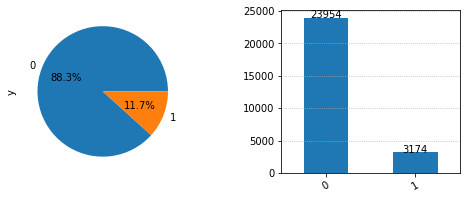

In [32]:
def arrange_bar(ax, sr):
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, horizontalalignment="center")
    ax.grid(axis='y', linestyle='dotted')
    [ax.text(i, count, count, horizontalalignment='center') for i, count in enumerate(sr)]

sr_survived = train['y'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
sr_survived.plot.pie(autopct="%1.1f%%", ax=axes[0])
sr_survived.plot.bar(ax=axes[1])

arrange_bar(axes[1], sr_survived)

plt.show()

In [33]:
# DICT_SURVIVED = {0: '0: Dead', 1: '1: Survived'}

def arrange_stack_bar(ax):
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, horizontalalignment="center")
    ax.grid(axis='y', linestyle='dotted')

def output_bars(df, column, index={}):    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)    

    # Key-Valueラベルなしの場合
    if len(index) == 0:
        df_vc = df.groupby([column])["y"].value_counts(
            sort=False).unstack()
        df[column].value_counts().plot.pie(ax=axes[0, 0], autopct="%1.1f%%")
        df.groupby([column])["y"].value_counts(
            sort=False, normalize=True).unstack().plot.bar(ax=axes[1, 1], stacked=True)

    # Key-Valueラベルありの場合
    else:
        df_vc = df.groupby([column])["y"].value_counts(
            sort=False).unstack()
        df[column].value_counts().rename(index).plot.pie(ax=axes[0, 0], autopct="%1.1f%%")
        df.groupby([column])["y"].value_counts(
            sort=False, normalize=True).unstack().plot.bar(ax=axes[1, 1], stacked=True)   

    df_vc.plot.bar(ax=axes[1, 0])

    for rect in axes[1, 0].patches:
        height = rect.get_height()

        # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
        axes[1, 0].annotate('{:.0f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    df_vc.plot.bar(ax=axes[0, 1], stacked=True)

    arrange_stack_bar(axes[0, 1])
    arrange_stack_bar(axes[1, 0])
    arrange_stack_bar(axes[1, 1])

    # データラベル追加
    [axes[0, 1].text(i, item.sum(), item.sum(), horizontalalignment='center') 
     for i, (_, item) in enumerate(df_vc.iterrows())]

    plt.show()

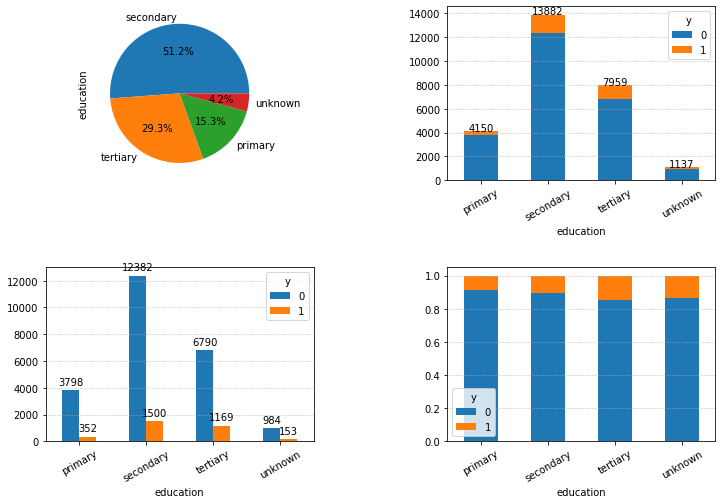

In [34]:
# secondary    23202
# tertiary     13301
# primary       6851
# unknown       1857
DICT_PCLASS = {1: '1: secondary', 2: '2: tertiary', 3: '3: primary', 4: '4: unknown'}
output_bars(train, 'education', DICT_PCLASS)

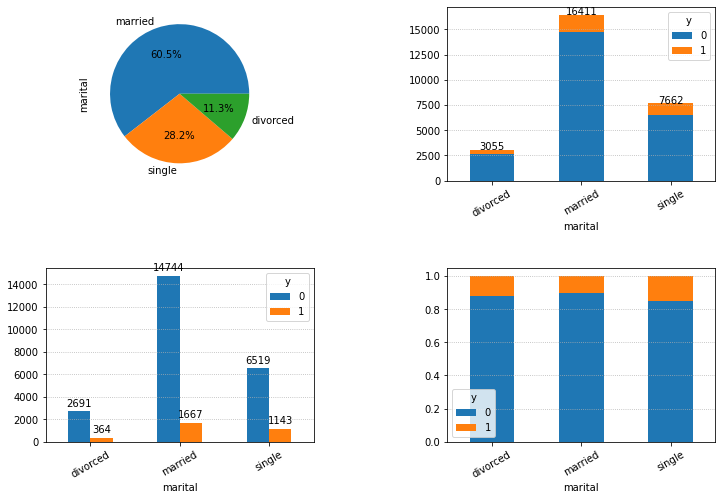

In [35]:
# married     27214
# single      12790
# divorced     5207
# Name: marital, dtype: int64
DICT_PCLASS = {1: '1: married', 2: '2: single', 3: '3: divorced'}
output_bars(train, 'marital', DICT_PCLASS)

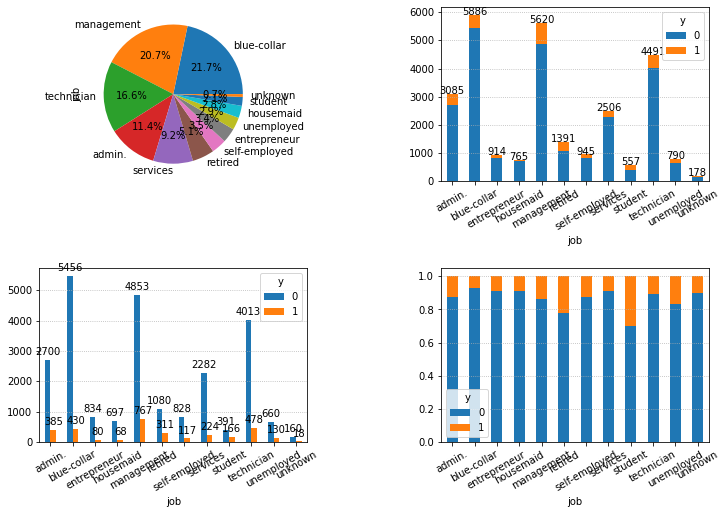

In [36]:
# blue-collar      9732
# management       9458
# technician       7597
# admin.           5171
# services         4154
# retired          2264
# self-employed    1579
# entrepreneur     1487
# unemployed       1303
# housemaid        1240
# student           938
# unknown           288
# Name: job, dtype: int64
DICT_PCLASS = {1: '1: blue-collar', 2: '2: management', 3: '3: technician', 4: "4: admin.", 5: "5: services", 6: "6: retired", 7: "7: self-employed", 8: "8: entrepreneur", 9: "9: unemployed", 10: "10: housemaid", 11: "11: student", 12: "12: unknown"}
output_bars(train, 'job', DICT_PCLASS)

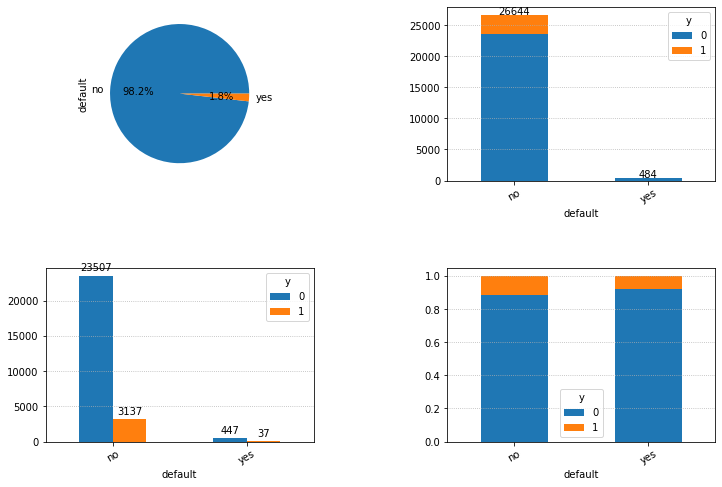

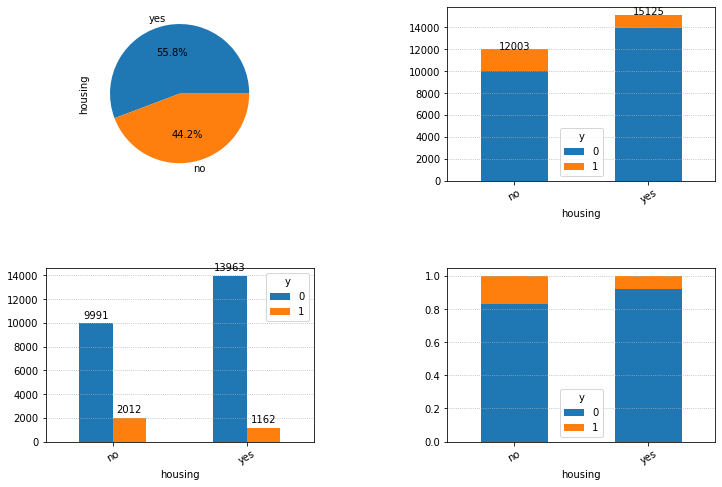

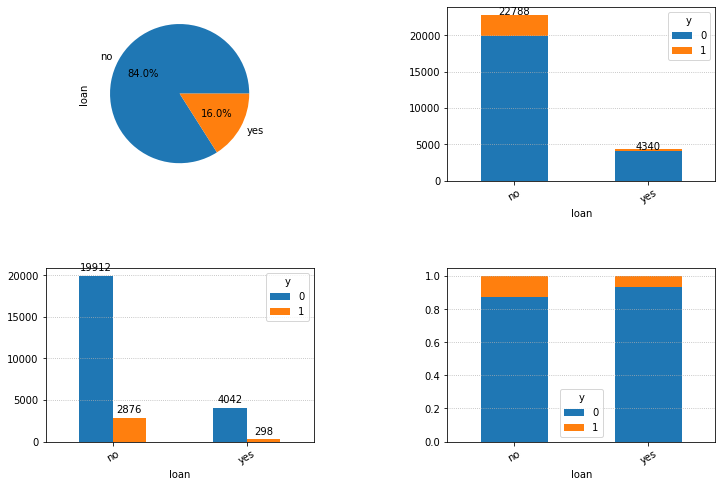

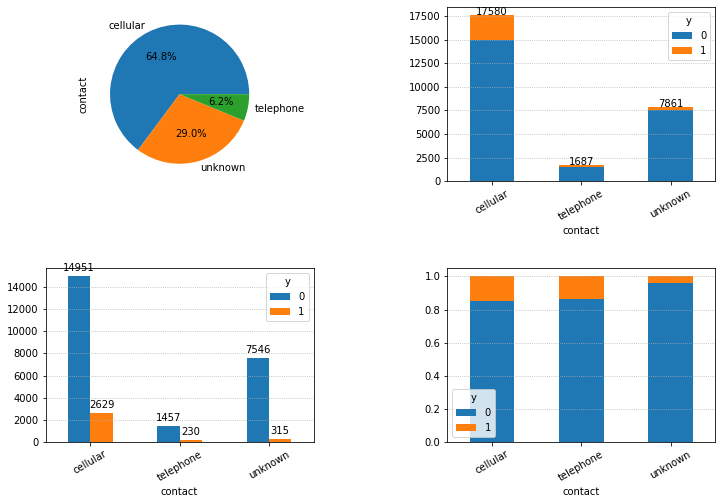

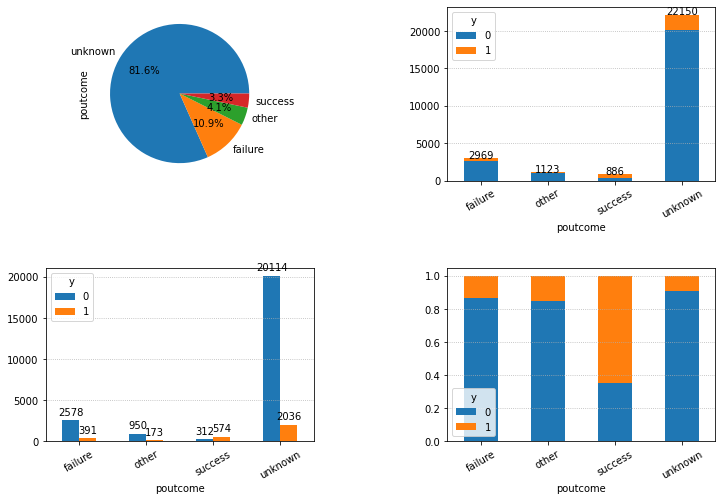

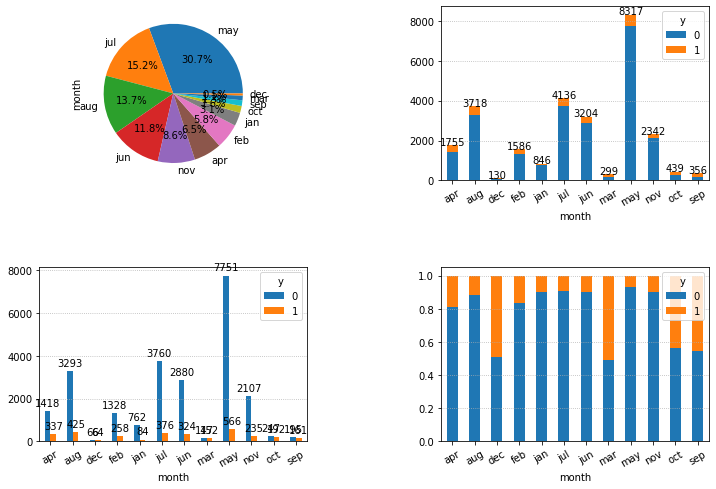

In [37]:
DICT_PCLASS = {1: '1: yes', 2: '2: no'}
output_bars(train, 'default', DICT_PCLASS)

DICT_PCLASS = {1: '1: yes', 2: '2: no'}
output_bars(train, 'housing', DICT_PCLASS)

DICT_PCLASS = {1: '1: yes', 2: '2: no'}
output_bars(train, 'loan', DICT_PCLASS)

DICT_PCLASS = {1: '1: cellilar', 2: '2: telephone', 3: "3: unknown"}
output_bars(train, 'contact', DICT_PCLASS)

DICT_PCLASS = {1: '1: success', 2: '2: failure', 3: "3: other", 4: "4: unknown"}
output_bars(train, 'poutcome', DICT_PCLASS)

DICT_PCLASS = {1: '1: jan', 2: '2: feb', 3: "3: mar", 4: "4: apr",5: '5: may', 6: '6: jun', 7: "7: jul", 8: "8: aug",9: '9: sep', 10: '10: oct', 11: "11: nov", 12: "12: dec"}
output_bars(train, 'month', DICT_PCLASS)


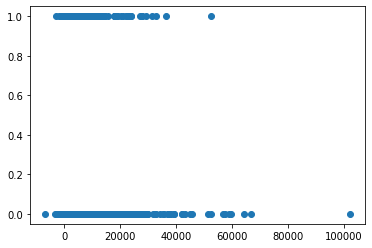

In [38]:
plt.scatter(train.balance,train.y)

(array([2.4879e+04, 2.0380e+03, 1.5800e+02, 3.1000e+01, 1.2000e+01,
        5.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ -6847. ,   4050.4,  14947.8,  25845.2,  36742.6,  47640. ,
         58537.4,  69434.8,  80332.2,  91229.6, 102127. ]),
 <a list of 10 Patch objects>)

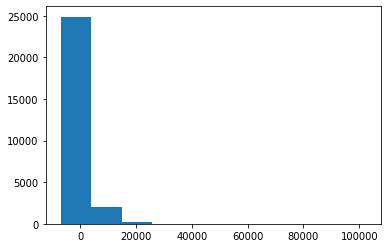

In [39]:
plt.hist(train.balance)

#Month-day

In [42]:
alldata.groupby("day").y.mean()

day
1     0.265957
2     0.135723
3     0.171131
4     0.158314
5     0.112199
6     0.103057
7     0.088909
8     0.106460
9     0.116183
10    0.230519
11    0.121012
12    0.149639
13    0.148891
14    0.121461
15    0.136676
16    0.145065
17    0.088087
18    0.107807
19    0.068269
20    0.058313
21    0.092457
22    0.191806
23    0.127208
24    0.161871
25    0.148077
26    0.125828
27    0.120464
28    0.074244
29    0.068868
30    0.173640
31    0.074074
Name: y, dtype: float64

In [47]:
alldata["day_range"] = 1
alldata.loc[alldata["day"] <= 10, "day_range"] = 1
alldata.loc[(alldata["day"] > 10) & (alldata["day"] <= 20), "day_range"] = 2
alldata.loc[alldata["day"] > 20, "day_range"] = 3
alldata

,y,TrainFlag,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,day_range
0,1.0,True,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,6.844815,1,-1,0,unknown,1
1,1.0,True,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,5.147494,10,-1,0,unknown,2
2,1.0,True,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,6.340359,1,595,2,failure,2
3,1.0,True,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,6.047372,1,-1,0,unknown,3
4,1.0,True,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,6.218600,1,9,2,success,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,NaN,False,18079,30,management,married,tertiary,no,32,yes,no,unknown,6,may,4.804021,3,-1,0,unknown,1
18079,NaN,False,18080,35,management,married,tertiary,no,1557,yes,yes,cellular,5,feb,5.416100,1,268,1,failure,1
18080,NaN,False,18081,33,housemaid,married,primary,no,1713,yes,no,unknown,8,may,3.091042,1,-1,0,unknown,1
18081,NaN,False,18082,37,blue-collar,married,secondary,no,-251,yes,no,cellular,12,may,4.983607,3,370,1,failure,2


In [48]:
list_month=alldata.month.unique()
list_month

array(['apr', 'feb', 'jan', 'jun', 'sep', 'may', 'aug', 'mar', 'jul',
       'nov', 'oct', 'dec'], dtype=object)

In [49]:
alldata["month_BME"] = 1
num=1
for i in list_month:
  for j in range(1,4):
    alldata.loc[(alldata["month"] == i) & (alldata["day_range"] == j), "month_BME"] = num
    num+=1

In [50]:
alldata

,y,TrainFlag,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,day_range,month_BME
0,1.0,True,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,6.844815,1,-1,0,unknown,1,1
1,1.0,True,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,5.147494,10,-1,0,unknown,2,5
2,1.0,True,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,6.340359,1,595,2,failure,2,2
3,1.0,True,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,6.047372,1,-1,0,unknown,3,9
4,1.0,True,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,6.218600,1,9,2,success,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,NaN,False,18079,30,management,married,tertiary,no,32,yes,no,unknown,6,may,4.804021,3,-1,0,unknown,1,16
18079,NaN,False,18080,35,management,married,tertiary,no,1557,yes,yes,cellular,5,feb,5.416100,1,268,1,failure,1,4
18080,NaN,False,18081,33,housemaid,married,primary,no,1713,yes,no,unknown,8,may,3.091042,1,-1,0,unknown,1,16
18081,NaN,False,18082,37,blue-collar,married,secondary,no,-251,yes,no,cellular,12,may,4.983607,3,370,1,failure,2,17


In [52]:
train=alldata.loc[alldata.TrainFlag]
# train=train.drop(delete_list,axis=1)
train.head()

,y,TrainFlag,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,day_range,month_BME
0,1.0,True,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,6.844815,1,-1,0,unknown,1,1
1,1.0,True,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,5.147494,10,-1,0,unknown,2,5
2,1.0,True,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,6.340359,1,595,2,failure,2,2
3,1.0,True,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,6.047372,1,-1,0,unknown,3,9
4,1.0,True,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,6.218600,1,9,2,success,3,3


#Age Range

In [53]:
# labels = [ "{0} - {1}".format(i, i + 9) for i in range(10, 100, 10) ]
# c = pd.cut(alldata.age, np.arange(10, 101, 10),
#            include_lowest=True, right=False,
#            labels=labels)
# print(alldata.groupby(c).mean())

In [54]:
# conditionlist = [
#     (alldata['age'] < 20) ,
#     (alldata['age'] >= 20) & (alldata['age'] <30),
#     (alldata['age'] >= 30) & (alldata['age'] <40),
#     (alldata['age'] >= 40) & (alldata['age'] <60),
#     (alldata['age'] >= 60) & (alldata['age'] <70),
#     (alldata['age'] >= 70) & (alldata['age'] <80),
#     (alldata['age'] >= 80) & (alldata['age'] <90),
#     (alldata['age'] >= 90)
#     ]
# choicelist = ['10s', '20s', '30s','40,50s', '60s', '70s', '80s','90s']
# alldata['Age_Range'] = np.select(conditionlist, choicelist, default='Not Specified')
# alldata

In [55]:
# # delete_list=["TrainFlag","id"]
# train=alldata.loc[alldata.TrainFlag]
# # train=train.drop(delete_list,axis=1)
# train.head()

In [56]:
alldata

,y,TrainFlag,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,day_range,month_BME
0,1.0,True,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,6.844815,1,-1,0,unknown,1,1
1,1.0,True,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,5.147494,10,-1,0,unknown,2,5
2,1.0,True,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,6.340359,1,595,2,failure,2,2
3,1.0,True,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,6.047372,1,-1,0,unknown,3,9
4,1.0,True,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,6.218600,1,9,2,success,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,NaN,False,18079,30,management,married,tertiary,no,32,yes,no,unknown,6,may,4.804021,3,-1,0,unknown,1,16
18079,NaN,False,18080,35,management,married,tertiary,no,1557,yes,yes,cellular,5,feb,5.416100,1,268,1,failure,1,4
18080,NaN,False,18081,33,housemaid,married,primary,no,1713,yes,no,unknown,8,may,3.091042,1,-1,0,unknown,1,16
18081,NaN,False,18082,37,blue-collar,married,secondary,no,-251,yes,no,cellular,12,may,4.983607,3,370,1,failure,2,17


#total接触

In [57]:
alldata["total_touch"]=alldata["campaign"]+alldata["pdays"]
train["total_touch"]=train["campaign"]+train["pdays"]

#カテゴリ変数

In [58]:
train_ctg=pd.get_dummies(train, drop_first=True)
train_ctg

,y,TrainFlag,id,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.0,True,1,39,1756,3,6.844815,1,-1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,True,2,51,1443,18,5.147494,10,-1,0,2,5,9,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1.0,True,3,36,436,13,6.340359,1,595,2,2,2,596,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,True,4,63,474,25,6.047372,1,-1,0,3,9,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,1.0,True,5,31,354,30,6.218600,1,9,2,3,3,10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,0.0,True,27124,42,1455,2,5.631212,2,269,2,1,4,271,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
27124,0.0,True,27125,34,719,15,5.891644,3,-1,0,2,17,2,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
27125,0.0,True,27126,36,49,8,6.003887,1,-1,0,1,16,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
27126,0.0,True,27127,33,209,12,4.330733,4,-1,0,2,20,3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [59]:
train_ctg.corr().style.background_gradient("summer_r")

,y,TrainFlag,id,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
y,1.000000,nan,-0.003555,0.020892,0.045826,-0.031058,0.334388,-0.076118,0.100930,0.083825,-0.013905,-0.009095,0.098777,-0.071971,-0.017122,-0.014899,0.030974,0.077087,0.004024,-0.027410,0.081543,-0.014642,0.025624,-0.004015,-0.059377,0.062806,-0.028497,0.059895,0.011429,-0.017005,-0.140307,-0.065630,0.015491,-0.152880,-0.003338,0.081025,0.035408,-0.009886,-0.034430,-0.018077,0.128539,-0.101259,-0.015932,0.127828,0.120275,0.023954,0.303472,-0.164607
TrainFlag,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
id,-0.003555,nan,1.000000,-0.005716,-0.000484,0.002974,0.000041,0.016867,-0.004526,-0.005425,0.001445,0.001161,-0.004009,0.004930,0.002452,-0.007486,0.001762,0.002032,0.002136,-0.002832,0.006958,-0.000162,0.000994,-0.006645,-0.001536,0.004125,0.001820,0.001805,-0.006171,0.003077,0.002384,0.007667,0.002542,0.006612,-0.000579,0.001377,0.003637,-0.009364,0.006728,0.004138,-0.008425,0.000794,-0.005086,0.000950,-0.004592,-0.003593,0.003610,0.004319
age,0.020892,nan,-0.005716,1.000000,0.095343,-0.008518,-0.004369,-0.001340,-0.025272,0.002946,-0.012889,0.038127,-0.025370,-0.045403,0.017521,0.084770,-0.022864,0.447656,-0.010758,-0.067086,-0.195871,-0.066126,0.001172,0.046513,0.287000,-0.426678,-0.088994,-0.084690,0.075773,-0.017648,-0.188127,-0.019236,0.172734,-0.018375,0.075772,0.022510,0.001077,-0.003969,-0.002527,0.053425,0.018493,-0.129600,0.035295,0.054322,0.034822,-0.020949,0.041961,-0.006139
balance,0.045826,nan,-0.000484,0.095343,1.000000,0.002067,0.020514,-0.016295,0.003613,0.012483,0.005249,0.029824,0.003112,-0.054156,0.019705,0.004116,0.073787,0.044341,0.017235,-0.039370,0.001307,-0.020306,0.009060,0.013031,0.023216,-0.010691,-0.076127,0.093879,0.011885,-0.065476,-0.069700,-0.084834,0.029580,-0.037410,0.011755,0.012391,-0.002249,-0.023359,-0.061448,0.029313,0.023175,-0.074690,0.120087,0.032993,0.025661,0.005972,0.031883,-0.029421
day,-0.031058,nan,0.002974,-0.008518,0.002067,1.000000,-0.060243,0.164880,-0.096889,-0.050009,0.938200,0.272951,-0.091956,-0.022529,0.000493,0.000194,0.017793,-0.009911,0.006658,-0.003227,-0.013439,0.029872,-0.000024,-0.014977,0.005898,-0.004687,-0.009887,0.023375,0.003140,0.007975,-0.033167,0.009938,0.018269,-0.031134,0.028250,-0.010295,-0.281975,0.252546,0.150190,-0.189308,-0.020583,-0.027398,0.093897,0.025721,-0.054429,-0.037827,-0.032890,0.089300
duration,0.334388,nan,0.000041,-0.004369,0.020514,-0.060243,1.000000,-0.209985,0.008214,0.000899,-0.042914,-0.016409,0.001677,-0.001048,-0.001606,-0.017402,-0.013934,0.038877,0.007323,0.001096,-0.004665,-0.007736,0.019452,-0.007195,-0.012760,0.009355,0.013436,-0.001985,0.000652,-0.008995,0.000335,-0.008026,-0.051172,-0.033233,-0.037645,0.025685,-0.007406,0.016800,0.011197,-0.050537,0.008300,0.013263,-0.011312,0.018084,0.015703,-0.015320,0.072835,-0.027204
campaign,-0.076118,nan,0.016867,-0.001340,-0.016295,0.164880,-0.209985,1.000000,-0.086220,-0.031557,0.146042,0.072450,-0.055195,0.011072,0.001953,-0.000506,0.018882,-0.036441,0.003895,-0.003580,-0.021345,0.025561,-0.019626,0.012294,0.031635,-0.018753,-0.020663,0.012524,0.005956,0.014263,-0.020902,0.010495,0.053009,0.007494,0.147964,-0.016173,-0.035041,-0.062675,0.100059,0.043924,-0.018269,-0.061945,-0.079705,-0.049433,-0.038191,-0.017237,-0.057249,0.105490
pdays,0.100930,nan,-0.004526,-0.025272,0.003

In [60]:
alldata_ctg=pd.get_dummies(alldata, drop_first=True)
alldata_ctg.head()


,y,TrainFlag,id,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.0,True,1,39,1756,3,6.844815,1,-1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,True,2,51,1443,18,5.147494,10,-1,0,2,5,9,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1.0,True,3,36,436,13,6.340359,1,595,2,2,2,596,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,True,4,63,474,25,6.047372,1,-1,0,3,9,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,1.0,True,5,31,354,30,6.218600,1,9,2,3,3,10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [61]:
alldata_ctg.tail()

,y,TrainFlag,id,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
18078,NaN,False,18079,30,32,6,4.804021,3,-1,0,1,16,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
18079,NaN,False,18080,35,1557,5,5.416100,1,268,1,1,4,269,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
18080,NaN,False,18081,33,1713,8,3.091042,1,-1,0,1,16,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
18081,NaN,False,18082,37,-251,12,4.983607,3,370,1,2,17,373,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
18082,NaN,False,18083,34,56,19,4.510860,2,-1,0,2,20,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


(array([2694., 5287., 5220., 3606., 5136., 5662., 6535., 2291., 2996.,
        5784.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

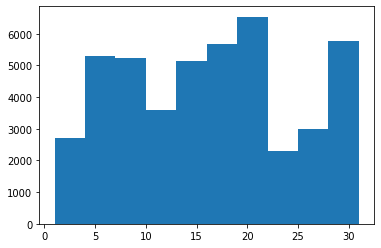

In [62]:
plt.hist(alldata_ctg.day)

In [63]:
# sns.swarmplot("y","day",data=alldata)

In [64]:
train

,y,TrainFlag,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,day_range,month_BME,total_touch
0,1.0,True,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,6.844815,1,-1,0,unknown,1,1,0
1,1.0,True,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,5.147494,10,-1,0,unknown,2,5,9
2,1.0,True,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,6.340359,1,595,2,failure,2,2,596
3,1.0,True,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,6.047372,1,-1,0,unknown,3,9,0
4,1.0,True,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,6.218600,1,9,2,success,3,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,0.0,True,27124,42,blue-collar,married,primary,no,1455,yes,no,cellular,2,feb,5.631212,2,269,2,other,1,4,271
27124,0.0,True,27125,34,services,single,secondary,no,719,yes,no,unknown,15,may,5.891644,3,-1,0,unknown,2,17,2
27125,0.0,True,27126,36,blue-collar,single,primary,no,49,yes,no,unknown,8,may,6.003887,1,-1,0,unknown,1,16,0
27126,0.0,True,27127,33,housemaid,married,primary,no,209,no,no,cellular,12,aug,4.330733,4,-1,0,unknown,2,20,3


#主成分分析

In [65]:
# ss = StandardScaler()
# train2= (train - train.mean()) / train.std()
train2=train
#目的変数を先頭コラムに
# cols=train2.columns.tolist()
# cols=cols[-3:]+cols[:-3]
# train2 =  train2[cols] 
train2

,y,TrainFlag,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,day_range,month_BME,total_touch
0,1.0,True,1,39,blue-collar,married,secondary,no,1756,yes,no,cellular,3,apr,6.844815,1,-1,0,unknown,1,1,0
1,1.0,True,2,51,entrepreneur,married,primary,no,1443,no,no,cellular,18,feb,5.147494,10,-1,0,unknown,2,5,9
2,1.0,True,3,36,management,single,tertiary,no,436,no,no,cellular,13,apr,6.340359,1,595,2,failure,2,2,596
3,1.0,True,4,63,retired,married,secondary,no,474,no,no,cellular,25,jan,6.047372,1,-1,0,unknown,3,9,0
4,1.0,True,5,31,management,single,tertiary,no,354,no,no,cellular,30,apr,6.218600,1,9,2,success,3,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,0.0,True,27124,42,blue-collar,married,primary,no,1455,yes,no,cellular,2,feb,5.631212,2,269,2,other,1,4,271
27124,0.0,True,27125,34,services,single,secondary,no,719,yes,no,unknown,15,may,5.891644,3,-1,0,unknown,2,17,2
27125,0.0,True,27126,36,blue-collar,single,primary,no,49,yes,no,unknown,8,may,6.003887,1,-1,0,unknown,1,16,0
27126,0.0,True,27127,33,housemaid,married,primary,no,209,no,no,cellular,12,aug,4.330733,4,-1,0,unknown,2,20,3


In [66]:
# train2=train2.drop(["id","TrainFlag"],axis=1)
train2_ctg=pd.get_dummies(train2, drop_first=True)

In [67]:
delete_list=["TrainFlag","id","poutcome_unknown"]
train2_ctg=train2_ctg.drop(delete_list,axis=1)
train2_ctg

,y,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,1.0,39,1756,3,6.844815,1,-1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,51,1443,18,5.147494,10,-1,0,2,5,9,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1.0,36,436,13,6.340359,1,595,2,2,2,596,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,63,474,25,6.047372,1,-1,0,3,9,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1.0,31,354,30,6.218600,1,9,2,3,3,10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,0.0,42,1455,2,5.631212,2,269,2,1,4,271,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
27124,0.0,34,719,15,5.891644,3,-1,0,2,17,2,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
27125,0.0,36,49,8,6.003887,1,-1,0,1,16,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
27126,0.0,33,209,12,4.330733,4,-1,0,2,20,3,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
# train2_ctg[train2_ctg.columns[1:]]= (train2_ctg[train2_ctg.columns[1:]] - train2_ctg[train2_ctg.columns[1:]].mean()) / train2_ctg[train2_ctg.columns[1:]].std()
# train2_ctg

In [69]:
# plotting.scatter_matrix(train2, figsize=(20, 20), c=list(train2.iloc[:, 0]), alpha=0.5)
# plt.show()

In [70]:
#主成分分析器
#主成分分析の実行
pca = PCA()
pca.fit(train2_ctg[train2_ctg.columns[1:]])
# データを主成分空間に写像
feature = pca.transform(train2_ctg[train2_ctg.columns[1:]])

In [71]:
# 主成分得点
pca_df=pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(train2_ctg[train2_ctg.columns[1:]].columns))])

pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44
0,400.187548,-59.827637,-3.135198,-20.995154,-4.531800,-1.021648,-0.160828,-1.540522,0.591439,-0.126708,-0.721096,0.203585,-0.757933,-0.297572,-0.033657,-0.293201,0.245344,-0.187358,-0.066391,0.127986,-0.165219,0.085115,0.031585,0.089433,-0.183557,-0.011437,0.003678,-0.006966,0.079979,0.166759,-0.171280,-0.026247,-0.104194,-0.137441,0.084611,-0.230021,0.018072,-0.110095,-0.124977,-0.046943,0.058505,0.023123,1.539370e-15,-7.738301e-14
1,87.192823,-53.573510,9.200547,-6.438655,-12.020312,8.662997,-0.177337,-0.492760,-0.406384,-0.260644,-0.491417,0.093556,-0.248494,-0.162648,-0.044794,0.049408,-0.516122,0.521547,-0.415434,0.022209,0.056228,-0.134885,-0.502243,-0.280331,0.318430,-0.296364,-0.083531,-0.687735,0.217072,-0.365850,0.075750,-0.086310,0.163074,0.528499,0.076142,0.063606,-0.020230,0.049285,0.039705,-0.041024,-0.000160,0.004745,1.261814e-15,-1.609303e-13
2,-919.679030,783.144718,-3.682460,-4.774773,-8.227910,-0.786528,-4.360770,-1.112467,-1.718838,-0.117312,0.376738,0.339156,0.456578,0.279415,-0.225331,0.145025,0.060396,-0.379167,-0.039779,0.148436,0.028766,0.160590,-0.037368,-0.172798,0.006807,-0.086410,-0.150539,-0.052253,0.049825,0.112937,-0.516459,0.340496,0.048812,-0.087127,0.125517,-0.238426,0.009349,-0.122925,-0.149220,-0.028792,0.048002,0.005993,-4.955435e-15,-2.140841e-13
3,-881.803494,-59.855347,21.712760,0.279794,-13.339214,-3.051715,-0.141830,-0.839258,0.039931,-0.726208,-0.231967,-0.139108,-0.066813,-0.107182,-0.368042,0.003250,-0.145809,0.069088,-0.225852,0.267507,-0.155433,-0.301024,-0.050100,-0.026134,-0.464638,0.530695,0.177501,-0.001133,0.085336,0.533649,-0.277727,-0.145650,0.388868,0.009349,-0.219331,0.250648,-0.036421,0.018340,0.050392,-0.071040,-0.017774,0.026642,1.039769e-15,-2.547939e-13
4,-1001.812407,-45.601504,-10.521594,1.565764,-19.679118,-3.426652,1.900691,-0.999260,-1.604477,-0.138679,0.284359,0.133588,-0.120922,0.000092,-0.335609,0.055997,0.013282,-0.137501,-0.301757,-0.156406,0.009371,0.096149,0.037721,-0.038165,-0.232732,0.153834,-0.549767,0.043694,0.030334,-0.079698,0.048049,-0.362778,-0.660086,0.166629,-0.135116,-0.135132,-0.018298,-0.148992,-0.171241,-0.017530,0.036827,0.016853,9.981359e-16,2.203851e-13


In [72]:
# 寄与率
pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(train2_ctg[train2_ctg.columns[1:]].columns))])

,0
PC1,9.977462e-01
PC2,2.224156e-03
PC3,1.235400e-05
PC4,9.334287e-06
PC5,5.359487e-06
PC6,1.566834e-06
PC7,5.700828e-07
PC8,9.748914e-08
PC9,5.658253e-08
PC10,4.055803e-08


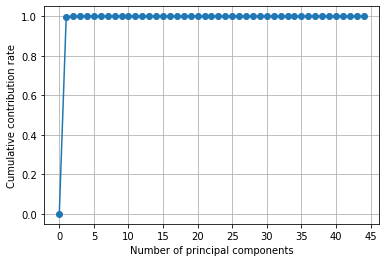

In [73]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

In [74]:
# PCA の固有値
pd.DataFrame(pca.explained_variance_, index=["PC{}".format(x + 1) for x in range(len(train2_ctg[train2_ctg.columns[1:]].columns))])

,0
PC1,9.019844e+06
PC2,2.010686e+04
PC3,1.116829e+02
PC4,8.438399e+01
PC5,4.845094e+01
PC6,1.416452e+01
PC7,5.153673e+00
PC8,8.813232e-01
PC9,5.115184e-01
PC10,3.666535e-01


In [75]:
# PCA の固有ベクトル
DF=pd.DataFrame(pca.components_, columns=train2_ctg.columns[1:], index=["PC{}".format(x + 1) for x in range(len(train2_ctg[train2_ctg.columns[1:]].columns))])
DF

,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
PC1,0.000337,9.999999e-01,5.737330e-06,6.566771e-06,-0.000017,0.000121,1.040883e-05,0.000001,0.000080,0.000104,-7.432703e-06,1.183898e-06,2.268701e-07,9.957177e-06,3.256419e-06,1.052264e-06,-3.795875e-06,6.170207e-08,-2.513095e-06,5.072253e-07,3.503211e-07,3.779117e-06,-1.602621e-06,-1.267064e-05,1.423267e-05,7.929947e-07,-2.886008e-06,-1.152684e-05,-1.035527e-05,2.378594e-06,-5.651322e-06,0.000001,2.849472e-07,-1.756896e-07,-0.000001,-0.000007,0.000003,8.056708e-07,-0.000011,0.000011,0.000001,9.723994e-07,3.963308e-07,1.887043e-06
PC2,-0.001930,-1.579591e-04,-5.579595e-03,3.334938e-05,-0.001561,0.707834,7.445692e-03,-0.000446,-0.007470,0.706273,5.392336e-05,-1.814251e-05,-3.286344e-05,-3.963112e-05,-2.037103e-05,-1.862837e-05,1.461694e-05,2.489638e-05,-1.592184e-05,-8.085254e-06,-8.818590e-06,-8.531760e-05,7.963780e-05,7.959469e-05,-3.436721e-05,-9.518807e-06,-2.909241e-05,4.511396e-04,-4.816177e-05,2.710378e-05,-8.032225e-04,-0.000265,2.348683e-05,1.261115e-04,0.000064,-0.000347,-0.000254,1.981835e-05,0.000254,0.000010,0.000051,6.670425e-05,5.615565e-04,2.761512e-04
PC3,0.998050,-3.412565e-04,-3.341415e-04,-6.366571e-04,0.000373,0.001458,3.161864e-03,-0.000296,0.055670,0.001831,-1.651097e-03,2.742258e-04,1.319567e-03,-1.088045e-03,9.281015e-03,-2.093975e-04,-1.740900e-03,-2.637886e-03,-2.231527e-03,-1.690073e-05,3.404294e-04,1.328759e-02,-1.826883e-02,-3.880162e-03,-3.972890e-03,1.397362e-03,-1.385464e-04,-8.532352e-03,-2.888745e-04,3.970792e-03,-1.326964e-03,0.002509,1.911152e-04,-3.033095e-04,-0.000135,0.000638,0.001038,1.991174e-04,-0.005347,0.001140,0.000752,3.530075e-04,-2.280353e-04,7.797063e-04
PC4,-0.035173,-4.301567e-05,7.658851e-01,-6.034177e-03,0.060146,-0.023621,-1.981079e-03,0.068133,0.633535,0.036525,-2.039560e-03,1.519983e-04,-3.713627e-05,1.735627e-03,-5.567083e-04,2.726818e-04,-4.440471e-05,-1.323327e-04,1.588603e-03,-3.116277e-04,-1.698880e-04,4.645954e-04,-3.653842e-04,-5.389756e-04,2.292477e-03,-3.196569e-04,2.867293e-04,-2.195088e-03,1.985013e-03,1.214475e-03,-7.940334e-03,0.002895,6.088984e-04,-1.064499e-02,0.001448,0.013556,-0.011418,3.047096e-04,-0.001414,0.009441,0.002088,-7.400412e-04,-2.503750e-04,1.657493e-04
PC5,-0.043276,-4.464019e-05,-6.308912e-01,5.231004e-03,-0.041077,0.021960,3.228852e-03,-0.051608,0.770817,-0.019117,-2.057036e-03,3.655632e-04,3.522782e-05,1.791608e-03,-4.279973e-04,3.116470e-04,1.139695e-04,1.788397e-04,3.038126e-04,-5.899858e-04,-1.031880e-05,3.437502e-04,-3.941219e-04,1.296585e-05,2.045140e-03,-8.248281e-04,4.063422e-04,-1.766448e-03,3.350588e-03,1.127919e-03,-1.000536e-02,0.003904,1.408043e-03,-5.008502e-03,-0.008945,0.014982,-0.006822,1.175209e-03,-0.000235,0.013092,0.003422,-9.162756e-05,-5.525239e-04,1.014872e-03
PC6,-0.000242,2.196926e-05,-8.859943e-02,-5.458664e-02,0.811818,-0.404953,4.667790e-04,-0.009596,-0.007932,0.406865,1.827194e-03,5.675446e-05,-7.481206e-05,1.719587e-03,-2.096239e-03,8.587448e-05,-2.682763e-04,-6.534099e-04,1.887145e-03,-8.921394e-04,3.251996e-04,3.923404e-03,-2.006408e-03,-2.603426e-03,1.071338e-03,3.028973e-04,3.427757e-04,-1.152403e-03,4.945463e-04,3.274448e-03,4.295676e-04,0.012644,-2.672618e-04,1.957954e-03,-0.005007,0.005349,0.007157,-3.877020e-04,-0.006786,-0.007828,-0.001876,-6.808275e-04,6.324031e-04,-1.930085e-03
PC7,-0.003105,-8.571335e-06,3.541735e-03,-1.076184e-03,-0.000151,-0.005195,9.996931e-01,0.001243,-0.001502,-0.005346,-5.798460e-03,-1.134528e-04,1.809159e-05,4.071084e-03,4.566650e-04,2.994220e-0

In [76]:
DF.iloc[0,:].values

array([ 3.36781766e-04,  9.99999927e-01,  5.73732987e-06,  6.56677128e-06,
       -1.69645438e-05,  1.21007052e-04,  1.04088290e-05,  1.34863574e-06,
        7.95547147e-05,  1.04042508e-04, -7.43270332e-06,  1.18389832e-06,
        2.26870099e-07,  9.95717738e-06,  3.25641892e-06,  1.05226441e-06,
       -3.79587488e-06,  6.17020695e-08, -2.51309468e-06,  5.07225317e-07,
        3.50321103e-07,  3.77911736e-06, -1.60262065e-06, -1.26706422e-05,
        1.42326714e-05,  7.92994663e-07, -2.88600830e-06, -1.15268379e-05,
       -1.03552663e-05,  2.37859438e-06, -5.65132171e-06,  1.34594933e-06,
        2.84947229e-07, -1.75689648e-07, -1.35190753e-06, -7.35504742e-06,
        3.14995332e-06,  8.05670768e-07, -1.14666706e-05,  1.12301199e-05,
        1.38615826e-06,  9.72399400e-07,  3.96330758e-07,  1.88704313e-06])

In [77]:
DF.iloc[0,:].values[0]

0.000336781765980529

In [78]:
DF.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'day_range', 'month_BME', 'total_touch', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'poutcome_other', 'poutcome_success'],
      dtype='object')

In [79]:
DF.columns[0]

'age'

In [80]:
len(DF.columns)

44

In [81]:
alldata_ctg

,y,TrainFlag,id,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.0,True,1,39,1756,3,6.844815,1,-1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,True,2,51,1443,18,5.147494,10,-1,0,2,5,9,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1.0,True,3,36,436,13,6.340359,1,595,2,2,2,596,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,True,4,63,474,25,6.047372,1,-1,0,3,9,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,1.0,True,5,31,354,30,6.218600,1,9,2,3,3,10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,NaN,False,18079,30,32,6,4.804021,3,-1,0,1,16,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
18079,NaN,False,18080,35,1557,5,5.416100,1,268,1,1,4,269,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
18080,NaN,False,18081,33,1713,8,3.091042,1,-1,0,1,16,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
18081,NaN,False,18082,37,-251,12,4.983607,3,370,1,2,17,373,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [82]:
# alldata_ctg[alldata_ctg.columns[3:]]=(alldata_ctg[alldata_ctg.columns[3:]] - alldata_ctg[alldata_ctg.columns[3:]].mean())/alldata_ctg[alldata_ctg.columns[3:]].std()

In [83]:
alldata_ctg

,y,TrainFlag,id,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,1.0,True,1,39,1756,3,6.844815,1,-1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,True,2,51,1443,18,5.147494,10,-1,0,2,5,9,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,1.0,True,3,36,436,13,6.340359,1,595,2,2,2,596,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,True,4,63,474,25,6.047372,1,-1,0,3,9,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,1.0,True,5,31,354,30,6.218600,1,9,2,3,3,10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,NaN,False,18079,30,32,6,4.804021,3,-1,0,1,16,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
18079,NaN,False,18080,35,1557,5,5.416100,1,268,1,1,4,269,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
18080,NaN,False,18081,33,1713,8,3.091042,1,-1,0,1,16,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
18081,NaN,False,18082,37,-251,12,4.983607,3,370,1,2,17,373,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [84]:
alldata_ctg["PC1"]=0
# alldata_ctg["PC2"]=0
# alldata_ctg["PC3"]=0
# alldata_ctg["PC4"]=0
# alldata_ctg["PC5"]=0
# alldata_ctg["PC6"]=0
# alldata_ctg["PC7"]=0
# alldata_ctg["PC8"]=0
# alldata_ctg["PC9"]=0
# alldata_ctg["PC10"]=0
# alldata_ctg["PC11"]=0
alldata_ctg

,y,TrainFlag,id,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,PC1
0,1.0,True,1,39,1756,3,6.844815,1,-1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1.0,True,2,51,1443,18,5.147494,10,-1,0,2,5,9,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,1.0,True,3,36,436,13,6.340359,1,595,2,2,2,596,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,True,4,63,474,25,6.047372,1,-1,0,3,9,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,1.0,True,5,31,354,30,6.218600,1,9,2,3,3,10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,NaN,False,18079,30,32,6,4.804021,3,-1,0,1,16,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
18079,NaN,False,18080,35,1557,5,5.416100,1,268,1,1,4,269,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
18080,NaN,False,18081,33,1713,8,3.091042,1,-1,0,1,16,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
18081,NaN,False,18082,37,-251,12,4.983607,3,370,1,2,17,373,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [85]:
for i in range(len(DF.columns)):
  alldata_ctg["PC1"]+=alldata_ctg[DF.columns[i]] * DF.iloc[0,:].values[i]
  # alldata_ctg["PC2"]+=alldata_ctg[DF.columns[i]] * DF.iloc[1,:].values[i]
  # alldata_ctg["PC3"]+=alldata_ctg[DF.columns[i]] * DF.iloc[2,:].values[i]
  # alldata_ctg["PC4"]+=alldata_ctg[DF.columns[i]] * DF.iloc[3,:].values[i]
  # alldata_ctg["PC5"]+=alldata_ctg[DF.columns[i]] * DF.iloc[4,:].values[i]
  # alldata_ctg["PC6"]+=alldata_ctg[DF.columns[i]] * DF.iloc[5,:].values[i]
  # alldata_ctg["PC7"]+=alldata_ctg[DF.columns[i]] * DF.iloc[6,:].values[i]
  # alldata_ctg["PC8"]+=alldata_ctg[DF.columns[i]] * DF.iloc[7,:].values[i]
  # alldata_ctg["PC9"]+=alldata_ctg[DF.columns[i]] * DF.iloc[8,:].values[i]
  # alldata_ctg["PC10"]+=alldata_ctg[DF.columns[i]] * DF.iloc[9,:].values[i]
  # alldata_ctg["PC11"]+=alldata_ctg[DF.columns[i]] * DF.iloc[10,:].values[i]

In [86]:
alldata_ctg

,y,TrainFlag,id,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,PC1
0,1.0,True,1,39,1756,3,6.844815,1,-1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1756.012983
1,1.0,True,2,51,1443,18,5.147494,10,-1,0,2,5,9,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1443.018258
2,1.0,True,3,36,436,13,6.340359,1,595,2,2,2,596,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,436.146405
3,1.0,True,4,63,474,25,6.047372,1,-1,0,3,9,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,474.021941
4,1.0,True,5,31,354,30,6.218600,1,9,2,3,3,10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,354.013028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,NaN,False,18079,30,32,6,4.804021,3,-1,0,1,16,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,32.011477
18079,NaN,False,18080,35,1557,5,5.416100,1,268,1,1,4,269,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1557.072474
18080,NaN,False,18081,33,1713,8,3.091042,1,-1,0,1,16,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1713.012166
18081,NaN,False,18082,37,-251,12,4.983607,3,370,1,2,17,373,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-250.902563


#train tesutに分ける

In [87]:
# delete_list=["TrainFlag","id","poutcome_unknown"]
train=alldata_ctg.loc[alldata_ctg.TrainFlag]
train=train.drop(delete_list,axis=1)
train.head()

,y,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,PC1
0,1.0,39,1756,3,6.844815,1,-1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1756.012983
1,1.0,51,1443,18,5.147494,10,-1,0,2,5,9,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1443.018258
2,1.0,36,436,13,6.340359,1,595,2,2,2,596,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,436.146405
3,1.0,63,474,25,6.047372,1,-1,0,3,9,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,474.021941
4,1.0,31,354,30,6.218600,1,9,2,3,3,10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,354.013028


In [88]:
test=alldata_ctg.loc[~alldata_ctg.TrainFlag]
test=test[test.columns[1:]]
test=test.drop(delete_list,axis=1)
test.head()

,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,PC1
0,30,1028,4,7.165493,2,-1,0,1,4,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1028.010389
1,39,426,18,6.936343,1,-1,0,2,11,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,426.014003
2,38,-572,5,3.258097,24,-1,0,1,10,23,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,-571.984463
3,34,-476,27,4.521789,4,-1,0,3,18,3,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,-475.986816
4,37,62,31,6.001415,2,-1,0,3,27,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,62.014772


#model

##XGBoost

In [89]:
def xgb_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, loop_counts):
    # データを格納する
    # 学習用
    xgb_train = xgb.DMatrix(X_train_cv, label=y_train_cv)
    # 検証用
    xgb_eval = xgb.DMatrix(X_eval_cv, label=y_eval_cv)
    # テスト用
    #xgb_test = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        'objective':  'binary:logistic',#'loss_function': 'RMSE',  # 多値分類問題
        # # 'num_class': 2,                 # 目的変数のクラス数
        # 'learning_rate': 0.1,           # 学習率
        # # 'eval_metric': 'mlogloss'       # 学習用の指標 (Multiclass logloss)
        'eval_metric': 'logloss',
        # 'eval_metric': 'rmse',
        # 'objective': 'multi:softprob',  # 多値分類問題
        # 'num_class': 2,                 # 目的変数のクラス数
        'learning_rate': 0.1,           # 学習率
        # 'eval_metric': 'mlogloss'       # 学習用の指標 (Multiclass logloss)
    }
    # xgb_params = {
    #     "silent": 0,
    #     "max_depth": 50,
    #     "min_child_weight": 1,
    #     "eta": 0.2,
    #     "tree_method": "exact",
    #     "objective": 'reg:squarederror',
    #     "eval_metric": "rmse",
    #     # "predictor": "cpu_predictor" 
    #     'random_state':1234,
    #     }

    # 学習
    evals = [(xgb_train, 'train'), (xgb_eval, 'eval')] # 学習に用いる検証用データ
    evaluation_results = {}                            # 学習の経過を保存する箱
    bst = xgb.train(xgb_params,                        # 上記で設定したパラメータ
                    xgb_train,                         # 使用するデータセット
                    num_boost_round=1000,               # 学習の回数
                    early_stopping_rounds=5,          # アーリーストッピング
                    evals=evals,                       # 学習経過で表示する名称
                    evals_result=evaluation_results,   # 上記で設定した検証用データ
                    verbose_eval=0                     # 学習の経過の表示(非表示)
                    )

    print(xgb.plot_importance(bst))

    
    
    # 検証用データで予測
    y_pred = bst.predict(xgb_eval, ntree_limit=bst.best_ntree_limit)
    # y_pred_max = np.argmax(y_pred, axis=1)

    # model =XGBClassifier()
    # model=model.fit(X_train_cv,y_train_cv)
    # y_pred =model.predict(X_eval_cv)

    y_pred_max=np.where(y_pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

    print('Trial: ' + str(loop_counts))
    
    # Accuracy の計算
    accuracy = accuracy_score(y_eval_cv, y_pred_max)
    print('XGBoost Accuracy:', accuracy)

    # plt.plot(evaluation_results["train"]["rmse"], color = "red", label = "train")
    # plt.plot(evaluation_results["eval"]["rmse"], color = "blue", label = "eval")
    # plt.legend()
    # plt.show()

    # rmse_result=np.sqrt(mean_squared_error(y_eval_cv, y_pred))
    # print('XGBoost RMSE:', rmse_result)
    
    # return(bst, rmse_result,y_pred)
    return(bst, accuracy,y_pred)

##LIghtGBM

In [90]:
def lgbm_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv):
    # データを格納する
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            free_raw_data=False)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           free_raw_data=False)
    
    # パラメータを設定
    params = {'task': 'train',                # レーニング ⇔　予測predict
              'boosting_type': 'gbdt',        # 勾配ブースティング
              # 'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
              # 'objective': 'regression',
              # 'metric': 'rmse',      # 検証用データセットで、分類モデルの性能を測る指標
              # 'num_class': 3,                 # 目的変数のクラス数

              'objective': 'binary', # 目的 : 2クラス分類
              'metric': {'binary_error'}, # 評価指標 : 誤り率(= 1-正答率)
              # 'objective': 'multiclass', # 目的関数：多値分類、マルチクラス分類 
              # 'metric': 'multi_logloss', # 検証用データセットで、分類モデルの性能を測る指標 
              # 'num_class': 2, # 目的変数のクラス数 

              'learning_rate': 0.1,           # 学習率（初期値0.1）
              'num_leaves': 40,               # 決定木の複雑度を調整（初期値31）
              'min_data_in_leaf': 1,          # データの最小数（初期値20）
             }

    # 学習
    evaluation_results = {}                                # 学習の経過を保存する箱
    LGBM_model = lgb.train(params,                              # 上記で設定したパラメータ
                      lgb_train,                           # 使用するデータセット
                      num_boost_round=1000,                 # 学習の回数
                      valid_names=['train', 'valid'],      # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],    # モデルの検証に使用するデータセット
                      evals_result=evaluation_results,     # 学習の経過を保存
                      early_stopping_rounds=5,            # アーリーストッピングの回数
                      verbose_eval=0)                      # 学習の経過を表示する刻み（非表示）

    # 検証用データで予測
    y_pred = LGBM_model.predict(X_eval_cv, num_iteration=LGBM_model.best_iteration)
    # y_pred_max = np.argmax(y_pred)
    y_pred_max=np.where(y_pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

    # Accuracy の計算
    accuracy =accuracy_score(y_eval_cv, y_pred_max)
    print('LightGBM Accuracy:', accuracy)
    
    # rmse_result=np.sqrt(mean_squared_error(y_eval_cv, y_pred))
    # print('LightGBM RMSE:', rmse_result)
    
    # return(LGBM_model, rmse_result,y_pred)
    return(LGBM_model, accuracy, y_pred)

##Catboost

In [91]:
def catboost_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv):
    # データを格納する
    # 学習用
    CatBoost_train = Pool(X_train_cv, label=y_train_cv)
    # 検証用
    CatBoost_eval = Pool(X_eval_cv, label=y_eval_cv)

    # パラメータを設定
    params = {        
        # 'loss_function': 'RMSE',    # 多値分類問題
        'num_boost_round': 1000,          # 学習の回数
        'early_stopping_rounds': 5,       # アーリーストッピングの回数
        # 'loss_function': 'MultiClass',
    }

    # 学習
    catb = CatBoost(params)
    catb.fit(CatBoost_train, eval_set=[CatBoost_eval], verbose=False)

    # 検証用データで予測
    # y_pred = catb.predict(X_eval_cv)
    y_pred = catb.predict(X_eval_cv,prediction_type='RawFormulaVal')#RawFormulaValは生のデータという意味で、0〜1間の数値をとります。(予測が0.6432..のようになります。)
    # y_pred = catb.predict(X_eval_cv,prediction_type='Probability')
    # y_pred_max = np.argmax(y_pred, axis=1)

    y_pred_max=np.where(y_pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

    # Accuracy の計算
    accuracy = sum(y_eval_cv == y_pred_max) / len(y_eval_cv)
    print('CatBoost Accuracy:', accuracy)

    # rmse_result=np.sqrt(mean_squared_error(y_eval_cv, y_pred))
    # print('CatBoost RMSE:', rmse_result)
    
    # return(catb, rmse_result,y_pred)
    return(catb, accuracy,y_pred)

##1段目

AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 1
XGBoost Accuracy: 0.9113527460375968
LightGBM Accuracy: 0.9106155547364541
CatBoost Accuracy: 0.9089568743088832
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 2
XGBoost Accuracy: 0.9052709178031699
LightGBM Accuracy: 0.8829708809436049
CatBoost Accuracy: 0.9004791743457428
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 3
XGBoost Accuracy: 0.9072981938813122
LightGBM Accuracy: 0.8829708809436049
CatBoost Accuracy: 0.9050866199778843
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 4
XGBoost Accuracy: 0.9131797235023041
LightGBM Accuracy: 0.8829493087557604
CatBoost Accuracy: 0.9094930875576037
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 5
XGBoost Accuracy: 0.9091244239631336
LightGBM Accuracy: 0.8831336405529954
CatBoost Accuracy: 0.9126267281105991
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 6
XGBoost Accuracy: 0.9113527460375968
LightGBM Accuracy: 0.9106155547364541
CatBoost Accuracy: 0.9089568743088832
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 7


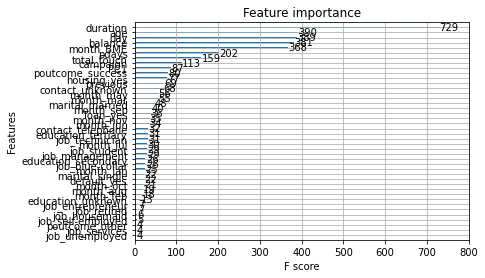

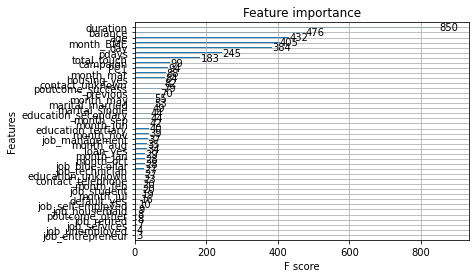

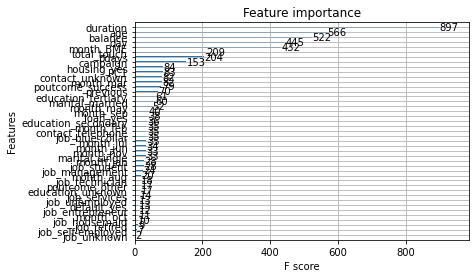

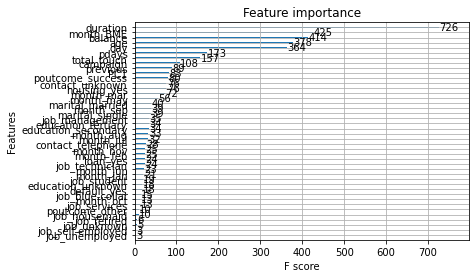

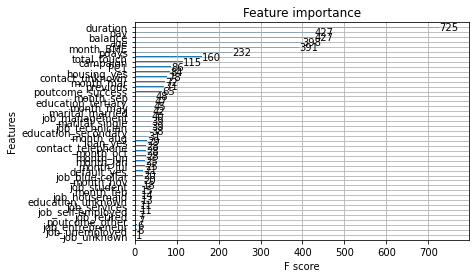

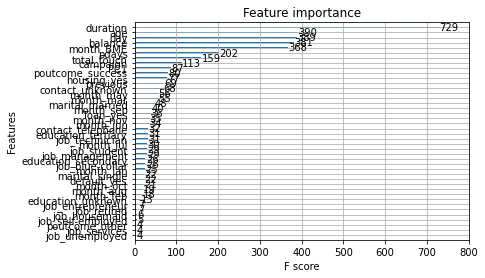

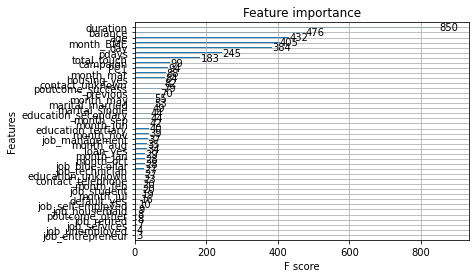

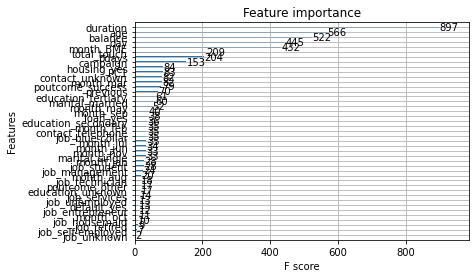

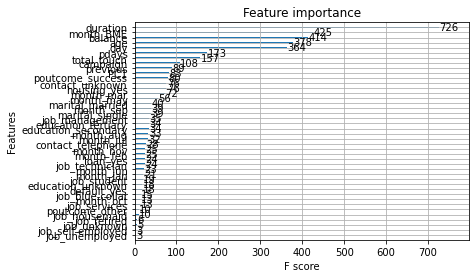

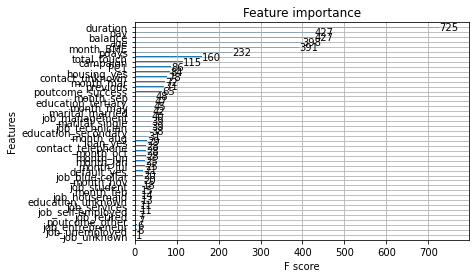

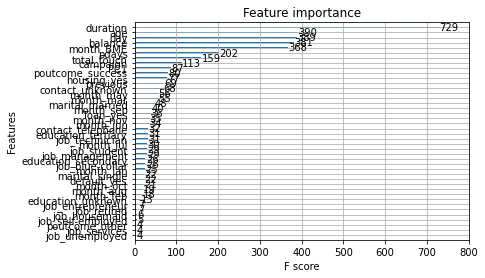

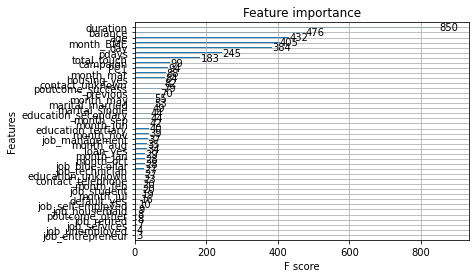

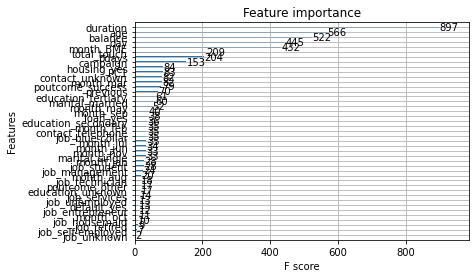

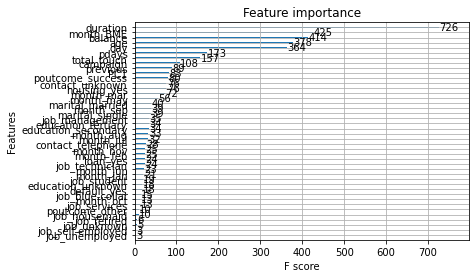

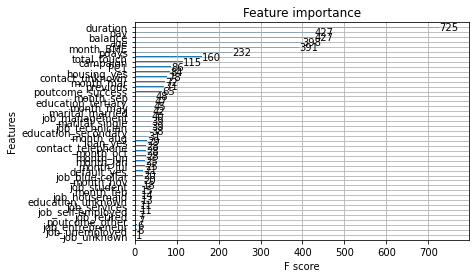

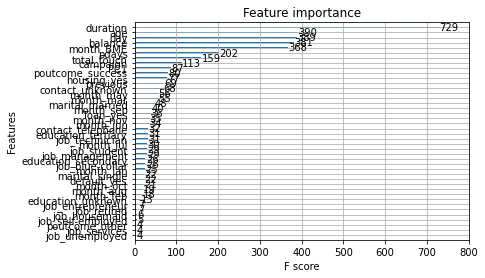

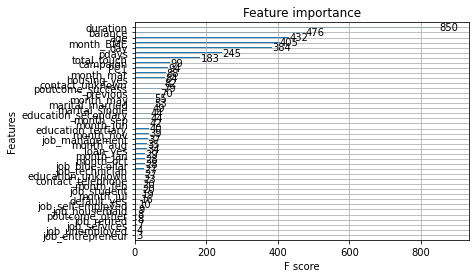

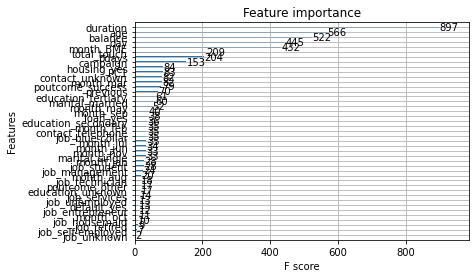

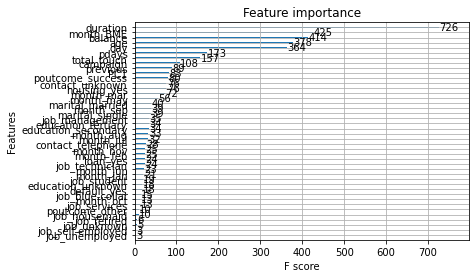

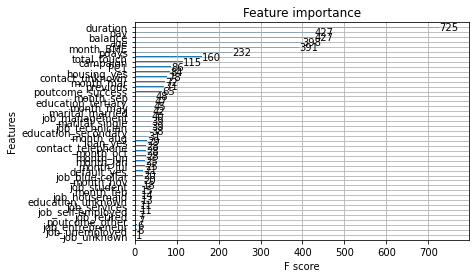

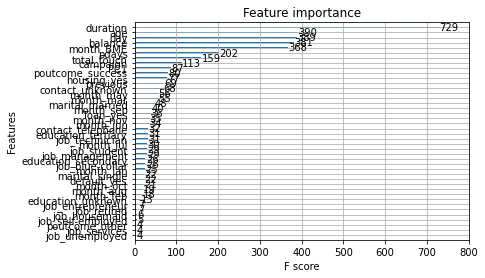

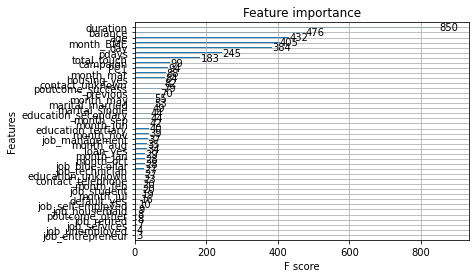

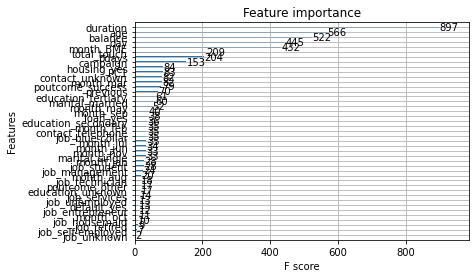

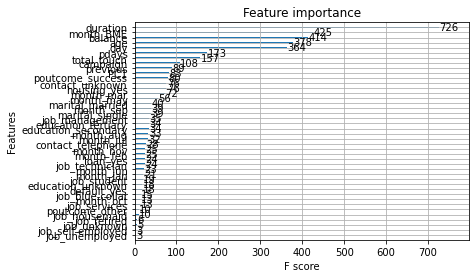

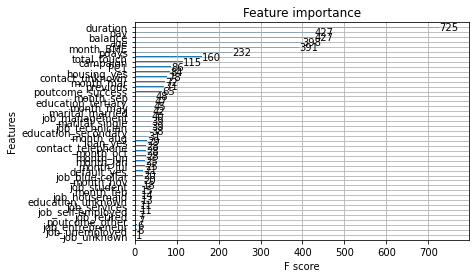

In [92]:
# 各5つのモデルを保存するリストの初期化
xgb_models = []
lgbm_models = []
catb_models = []
# 各5つのモデルの正答率を保存するリストの初期化
xgb_rmse_result = []
lgbm_rmse_result = []
catb_rmse_result = []
# 学習のカウンター
loop_counts = 1

# X=train[train.columns[1:]].values
# Y=train[train.columns[0]].values
df_X=train[train.columns[1:]]
y= train[train.columns[0]]

# # 各クラスの確率（3モデル*5seed*1クラス）
first_preds = pd.DataFrame(np.zeros((len(df_X), 3*5)))
first_prebs = pd.DataFrame(np.zeros((len(df_X), 3*5*2)))



for seed_no in range(5): 
        
    # 学習データの数だけの数列（0行から最終行まで連番）
    row_no_list = list(range(len(df_X)))

    # KFoldクラスをインスタンス化（これを使って5分割する）Stratified Kfoldは、分類問題にしか使えません
    K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=42)
    # #＃回帰問題でも＃回帰問題でもStratifiedKFoldが使えるように以下追記
    # num_bins = int(np.floor(1+np.log2(len(y))))
    # y_bin = pd.cut(y, bins=num_bins, labels=False)
    

    # KFoldクラスで分割した回数だけ実行（ここでは5回）
    # for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_bin):
    for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y):
        # ilocで取り出す行を指定
        X_train_cv = df_X.iloc[train_cv_no, :]
        y_train_cv = pd.Series(y).iloc[train_cv_no]
        X_eval_cv = df_X.iloc[eval_cv_no, :]
        y_eval_cv = pd.Series(y).iloc[eval_cv_no]
        
        # XGBoostの訓練を実行
        bst, bst_rmse, bst_pred = xgb_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, loop_counts)
        # LIghtGBMの訓練を実行
        LGBM_model, model_rmse, model_pred = lgbm_train_cv(X_train_cv, y_train_cv,X_eval_cv, y_eval_cv)
        # CatBoostの訓練を実行
        catb, catb_rmse, catb_pred = catboost_train_cv(X_train_cv, y_train_cv,X_eval_cv, y_eval_cv)
        # 実行回数のカウント
        loop_counts += 1
        
        # 学習が終わったモデルをリストに入れておく
        xgb_models.append(bst) 
        lgbm_models.append(LGBM_model) 
        catb_models.append(catb) 
        
        # 学習が終わったモデルの正答率をリストに入れておく
        xgb_rmse_result.append(bst_rmse) 
        lgbm_rmse_result.append(model_rmse) 
        catb_rmse_result.append(catb_rmse) 
        
        # # 検証データの各クラスの確率
        # for i in range(2):
        #     first_prebs.iloc[eval_cv_no, (seed_no * 2) + i] = bst_pred[:, i]
        #     first_prebs.iloc[eval_cv_no, (seed_no * 2) + 10 + i] = model_pred[:, i]
        #     first_prebs.iloc[eval_cv_no, (seed_no * 2) + 20 + i] = catb_pred[:, i]

        # # 検証データの結果
        first_preds.iloc[eval_cv_no, (seed_no * 3) ] =bst_pred
        first_preds.iloc[eval_cv_no, (seed_no * 3) + 1] = model_pred
        first_preds.iloc[eval_cv_no, (seed_no * 3) + 2] = catb_pred

In [93]:
first_preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.521348,0.173605,0.532774,0.521348,0.173605,0.532774,0.521348,0.173605,0.532774,0.521348,0.173605,0.532774,0.521348,0.173605,0.532774
1,0.119626,0.231858,0.378494,0.119626,0.231858,0.378494,0.119626,0.231858,0.378494,0.119626,0.231858,0.378494,0.119626,0.231858,0.378494
2,0.625894,0.130655,0.551223,0.625894,0.130655,0.551223,0.625894,0.130655,0.551223,0.625894,0.130655,0.551223,0.625894,0.130655,0.551223
3,0.448154,0.161046,0.324461,0.448154,0.161046,0.324461,0.448154,0.161046,0.324461,0.448154,0.161046,0.324461,0.448154,0.161046,0.324461
4,0.827148,0.135902,0.931115,0.827148,0.135902,0.931115,0.827148,0.135902,0.931115,0.827148,0.135902,0.931115,0.827148,0.135902,0.931115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27123,0.050336,0.108572,0.051286,0.050336,0.108572,0.051286,0.050336,0.108572,0.051286,0.050336,0.108572,0.051286,0.050336,0.108572,0.051286
27124,0.005970,0.014123,0.025519,0.005970,0.014123,0.025519,0.005970,0.014123,0.025519,0.005970,0.014123,0.025519,0.005970,0.014123,0.025519
27125,0.014367,0.027936,0.028432,0.014367,0.027936,0.028432,0.014367,0.027936,0.028432,0.014367,0.027936,0.028432,0.014367,0.027936,0.028432
27126,0.004455,0.107281,-0.007986,0.004455,0.107281,-0.007986,0.004455,0.107281,-0.007986,0.004455,0.107281,-0.007986,0.004455,0.107281,-0.007986


In [94]:
# 単独のモデルでの、テストデータの正答率
#スタッキングによる予測の１段目は、特徴量の抽出が目的なので、ここでの正答率はあまり気にしないでよいです。
print('XGBoost RMSE: ', np.array(xgb_rmse_result).mean())
print('LightGBM RMSE: ', np.array(lgbm_rmse_result).mean())
print('CatBoost RMSE: ', np.array(catb_rmse_result).mean())

XGBoost RMSE:  0.9092452010375035
LightGBM RMSE:  0.888528053186484
CatBoost RMSE:  0.9073284968601426


##スタッキングによる予測

In [95]:
loop_counts = 0

# 学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(first_preds, y.values,
                                                    test_size=0.2,
                                                    random_state=0)

# 予測結果の格納用のnumpy行列を作成
test_preds = np.zeros((len(y_test), 5))

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=0)
# #＃回帰問題でも＃回帰問題でもStratifiedKFoldが使えるように以下追記
# num_bins2 = int(np.floor(1+np.log2(len(y_train))))
# y_train_bin = pd.cut(y_train, bins=num_bins2, labels=False)

# KFoldクラスで分割した回数だけ実行（ここでは5回）
# for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train_bin):
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]

    # データを格納する
    # 学習用
    xgb_train = xgb.DMatrix(X_train_cv, label=y_train_cv)
    # 検証用
    xgb_eval = xgb.DMatrix(X_eval_cv, label=y_eval_cv)
    # テスト用
    xgb_test = xgb.DMatrix(X_test, label=y_test)

    xgb_params2 = {
        'objective':  'binary:logistic',
        # 'objective': 'multi:softprob',  # 多値分類問題
        # 'num_class': 2,                 # 目的変数のクラス数
        'learning_rate': 0.1,           # 学習率
        # 'eval_metric': 'mlogloss',       # 学習用の指標 (Multiclass logloss)
        'eval_metric': 'logloss',
        'random_state':1234,
        # 'objective': 'multi:softprob',  # 多値分類問題
        # 'num_class': 2,
    }
    # xgb_params2 = {
    #     "silent": 0,
    #     "max_depth": 10,
    #     "min_child_weight": 1,
    #     "eta": 0.1,
    #     "tree_method": "exact",
    #     "objective": 'reg:squarederror',
    #     "eval_metric": "rmse",
    #     # "predictor": "cpu_predictor" 
    #     'random_state':1234,
    #     }

    # 学習
    evals = [(xgb_train, 'train'), (xgb_eval, 'eval')] # 学習に用いる検証用データ
    evaluation_results = {}                            # 学習の経過を保存する箱
    bst2 = xgb.train(xgb_params2,                        # 上記で設定したパラメータ
                    xgb_train,                         # 使用するデータセット
                    num_boost_round=1000,               # 学習の回数
                    early_stopping_rounds=5,          # アーリーストッピング
                    evals=evals,                       # 学習経過で表示する名称
                    evals_result=evaluation_results,   # 上記で設定した検証用データ
                    verbose_eval=0                     # 学習の経過の表示(非表示)
                    )


    y_pred = bst2.predict(xgb_test, ntree_limit=bst2.best_ntree_limit)
    # y_pred_max = np.argmax(y_pred, axis=1)
    y_pred_max=np.where(y_pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す
    # y_pred_max = np.argmax(y_pred, axis=1)

    # testの予測を保存
    # test_preds[:, loop_counts] = y_pred
    test_preds[:, loop_counts] = y_pred_max
 
    print('Trial: ' + str(loop_counts))
    loop_counts += 1
    # Accuracy の計算
    accuracy = accuracy_score(y_test, y_pred_max)
    print('Accuracy:', accuracy)
    
    # rmse__ = np.sqrt(mean_squared_error(y_test, y_pred))
    # print('RMSE:', rmse__)

Trial: 0
Accuracy: 0.9107998525617398
Trial: 1
Accuracy: 0.9084039808330262
Trial: 2
Accuracy: 0.9091411721341688
Trial: 3
Accuracy: 0.9087725764835974
Trial: 4
Accuracy: 0.9067453004054552


In [96]:
import optuna

#学習データを説明変数と目的変数に分ける
# X=df_co_train[df_co_train.columns[1:]].values
# Y=df_co_train[df_co_train.columns[0]].values
X=train[train.columns[1:]].values
Y=train[train.columns[0]].values

# データを訓練データと正解データに7:3で分ける
X_train, X_test, y_train, y_test = train_test_split(first_preds, y.values,
                                                    test_size=0.2,
                                                    random_state=0)

#データをXGB専用のデータ型に変換
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

def objective(trial):
  # 探索したいパラメータの範囲を記述 例えば、trial.suggest_int(“max_depth”, 6, 9)ならmax_depthを6,7,8,9の中で動かしながら探索
  params = {
        "silent": 0,
        "max_depth": trial.suggest_int("max_depth", 6, 10),
        "min_child_weight": 1,
        "eta": trial.suggest_loguniform("eta", 0.01, 0.3),
        "tree_method": "exact",
        "objective": 'binary:logistic',
        'eval_metric': 'logloss',
        # "objective": 'reg:squarederror',
        # "eval_metric": "rmse",
        # "predictor": "cpu_predictor" 
        'random_state':1234,  
    }
    # モデル定義、学習
  cv_results = xgb.cv(
      params,
      dtrain,
      num_boost_round=1000,
      seed=1234,
      nfold=5, # CVの分割数
      # metrics={"rmse"},
      early_stopping_rounds=10
      )
    # 評価

  # return cv_results["test-rmse-mean"].min()
  return cv_results["test-logloss-mean"].min()

study=optuna.create_study()
study.optimize(objective,n_trials=50)

[I 2022-02-05 20:05:40,882] A new study created in memory with name: no-name-3658cfac-7cfa-4629-8193-25d7e62dc4c5
[I 2022-02-05 20:05:48,032] Trial 0 finished with value: 0.19938699999999998 and parameters: {'max_depth': 6, 'eta': 0.1492570756950598}. Best is trial 0 with value: 0.19938699999999998.
[I 2022-02-05 20:06:55,935] Trial 1 finished with value: 0.2005178 and parameters: {'max_depth': 7, 'eta': 0.012562308725258186}. Best is trial 0 with value: 0.19938699999999998.
[I 2022-02-05 20:07:26,479] Trial 2 finished with value: 0.2049468 and parameters: {'max_depth': 10, 'eta': 0.03475771438510309}. Best is trial 0 with value: 0.19938699999999998.
[I 2022-02-05 20:07:44,811] Trial 3 finished with value: 0.20546179999999997 and parameters: {'max_depth': 10, 'eta': 0.06274550734923762}. Best is trial 0 with value: 0.19938699999999998.
[I 2022-02-05 20:08:02,648] Trial 4 finished with value: 0.1994262 and parameters: {'max_depth': 6, 'eta': 0.04528165867053457}. Best is trial 0 with va

In [97]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value: 0.199139
  Params: 
    max_depth: 6
    eta: 0.02087664123218582


[0]	train-logloss:0.677426	eval-logloss:0.677524
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 3 rounds.
[1]	train-logloss:0.662335	eval-logloss:0.662617
[2]	train-logloss:0.647851	eval-logloss:0.648248
[3]	train-logloss:0.633933	eval-logloss:0.63445
[4]	train-logloss:0.620538	eval-logloss:0.621244
[5]	train-logloss:0.607676	eval-logloss:0.608507
[6]	train-logloss:0.595286	eval-logloss:0.596231
[7]	train-logloss:0.583353	eval-logloss:0.584442
[8]	train-logloss:0.57185	eval-logloss:0.573073
[9]	train-logloss:0.560756	eval-logloss:0.562145
[10]	train-logloss:0.550056	eval-logloss:0.551576
[11]	train-logloss:0.539743	eval-logloss:0.541397
[12]	train-logloss:0.529769	eval-logloss:0.531575
[13]	train-logloss:0.520118	eval-logloss:0.522058
[14]	train-logloss:0.510804	eval-logloss:0.512892
[15]	train-logloss:0.501792	eval-logloss:0.504013
[16]	train-logloss:0.493082	eval-logloss:0.495467
[17]	train-log

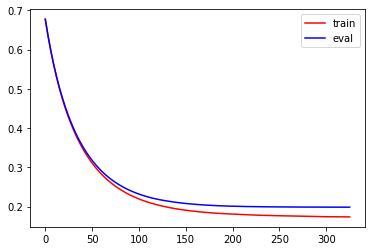

In [98]:
#訓練データはdtrain、評価用のテストデータはdvalidと設定
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
params = {
      "silent": 0,
      "max_depth": 50,
      "min_child_weight": 1,
      "eta": 0.20176532503411956,
      "tree_method": "exact",
      # "objective": 'reg:squarederror',
      "objective": 'binary:logistic',
      # "eval_metric": "rmse",
      'eval_metric': 'logloss',
      # "predictor": "cpu_predictor" 
      'random_state':1234,  
  }
params["max_depth"] = trial.params["max_depth"]
params["eta"] = trial.params["eta"]
results_dict = {}
XGBmodel2 = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=10000,
                  early_stopping_rounds=3,
                  evals=watchlist,
                  evals_result = results_dict,
                  )
plt.plot(results_dict["train"]["logloss"], color = "red", label = "train")
plt.plot(results_dict["eval"]["logloss"], color = "blue", label = "eval")
plt.legend()
plt.show()

#提出

In [99]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
8940,0.008528,0.012897,0.004497,0.008528,0.012897,0.004497,0.008528,0.012897,0.004497,0.008528,0.012897,0.004497,0.008528,0.012897,0.004497
12626,0.094459,0.107196,0.088222,0.094459,0.107196,0.088222,0.094459,0.107196,0.088222,0.094459,0.107196,0.088222,0.094459,0.107196,0.088222
23448,0.009713,0.013858,0.031790,0.009713,0.013858,0.031790,0.009713,0.013858,0.031790,0.009713,0.013858,0.031790,0.009713,0.013858,0.031790
24317,0.091515,0.107291,0.085465,0.091515,0.107291,0.085465,0.091515,0.107291,0.085465,0.091515,0.107291,0.085465,0.091515,0.107291,0.085465
15824,0.003333,0.007694,0.052656,0.003333,0.007694,0.052656,0.003333,0.007694,0.052656,0.003333,0.007694,0.052656,0.003333,0.007694,0.052656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0.002158,0.107486,-0.000813,0.002158,0.107486,-0.000813,0.002158,0.107486,-0.000813,0.002158,0.107486,-0.000813,0.002158,0.107486,-0.000813
19648,0.002782,0.107486,-0.014448,0.002782,0.107486,-0.014448,0.002782,0.107486,-0.014448,0.002782,0.107486,-0.014448,0.002782,0.107486,-0.014448
9845,0.001871,0.107291,-0.014072,0.001871,0.107291,-0.014072,0.001871,0.107291,-0.014072,0.001871,0.107291,-0.014072,0.001871,0.107291,-0.014072
10799,0.570497,0.173605,0.583594,0.570497,0.173605,0.583594,0.570497,0.173605,0.583594,0.570497,0.173605,0.583594,0.570497,0.173605,0.583594


In [100]:
test

,age,balance,day,duration,campaign,pdays,previous,day_range,month_BME,total_touch,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,PC1
0,30,1028,4,7.165493,2,-1,0,1,4,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1028.010389
1,39,426,18,6.936343,1,-1,0,2,11,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,426.014003
2,38,-572,5,3.258097,24,-1,0,1,10,23,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,-571.984463
3,34,-476,27,4.521789,4,-1,0,3,18,3,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,-475.986816
4,37,62,31,6.001415,2,-1,0,3,27,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,62.014772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,30,32,6,4.804021,3,-1,0,1,16,2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,32.011477
18079,35,1557,5,5.416100,1,268,1,1,4,269,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1557.072474
18080,33,1713,8,3.091042,1,-1,0,1,16,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1713.012166
18081,37,-251,12,4.983607,3,370,1,2,17,373,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-250.902563


In [101]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18083 entries, 0 to 18082
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  18083 non-null  int64  
 1   balance              18083 non-null  int64  
 2   day                  18083 non-null  int64  
 3   duration             18083 non-null  float64
 4   campaign             18083 non-null  int64  
 5   pdays                18083 non-null  int64  
 6   previous             18083 non-null  int64  
 7   day_range            18083 non-null  int64  
 8   month_BME            18083 non-null  int64  
 9   total_touch          18083 non-null  int64  
 10  job_blue-collar      18083 non-null  uint8  
 11  job_entrepreneur     18083 non-null  uint8  
 12  job_housemaid        18083 non-null  uint8  
 13  job_management       18083 non-null  uint8  
 14  job_retired          18083 non-null  uint8  
 15  job_self-employed    18083 non-null 

In [102]:
test_x_xgbst1=xgb.DMatrix(test)
lgb_test = lgb.Dataset(test, free_raw_data=False)
CatBoost_test = Pool(test)

test_first_preds = pd.DataFrame(np.zeros((len(test), 3*5)))#モデル数＊＊seed数

for seed in range(5):
  xgbst1 = bst.predict(test_x_xgbst1, ntree_limit=bst.best_ntree_limit)
  LGBM1=LGBM_model.predict(test, num_iteration=LGBM_model.best_iteration)
  catb1 = catb.predict(CatBoost_test,prediction_type='RawFormulaVal')
  # # 検証データの結果
  test_first_preds.iloc[:, (seed * 3) ] =xgbst1
  test_first_preds.iloc[:, (seed * 3) + 1] = LGBM1
  test_first_preds.iloc[:, (seed * 3) + 2] = catb1


In [103]:
test_first_preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.614031,0.172195,0.645762,0.614031,0.172195,0.645762,0.614031,0.172195,0.645762,0.614031,0.172195,0.645762,0.614031,0.172195,0.645762
1,0.593159,0.172195,0.546969,0.593159,0.172195,0.546969,0.593159,0.172195,0.546969,0.593159,0.172195,0.546969,0.593159,0.172195,0.546969
2,0.000949,0.107281,-0.001795,0.000949,0.107281,-0.001795,0.000949,0.107281,-0.001795,0.000949,0.107281,-0.001795,0.000949,0.107281,-0.001795
3,0.001388,0.107281,-0.001879,0.001388,0.107281,-0.001879,0.001388,0.107281,-0.001879,0.001388,0.107281,-0.001879,0.001388,0.107281,-0.001879
4,0.127964,0.116105,0.123702,0.127964,0.116105,0.123702,0.127964,0.116105,0.123702,0.127964,0.116105,0.123702,0.127964,0.116105,0.123702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,0.001864,0.107281,-0.004898,0.001864,0.107281,-0.004898,0.001864,0.107281,-0.004898,0.001864,0.107281,-0.004898,0.001864,0.107281,-0.004898
18079,0.054527,0.112085,0.053574,0.054527,0.112085,0.053574,0.054527,0.112085,0.053574,0.054527,0.112085,0.053574,0.054527,0.112085,0.053574
18080,0.001076,0.107281,-0.014748,0.001076,0.107281,-0.014748,0.001076,0.107281,-0.014748,0.001076,0.107281,-0.014748,0.001076,0.107281,-0.014748
18081,0.007127,0.107281,-0.017337,0.007127,0.107281,-0.017337,0.007127,0.107281,-0.017337,0.007127,0.107281,-0.017337,0.007127,0.107281,-0.017337


In [104]:
#2段

# bst2_predict=bst2.predict(xgb.DMatrix(test_first_preds), ntree_limit=bst2.best_ntree_limit)
bst2_predict = XGBmodel2.predict(xgb.DMatrix(test_first_preds), ntree_limit=XGBmodel2.best_ntree_limit)
bst2_predict

# bst2_predict_max=np.where(bst2_predict < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

len(bst2_predict)
# kaggleの課題として PassengerId 1-18083 を予測することが要求されているため
# idを生成しておく
id = np.arange(1,18084)

# Idと予測結果をデータフレーム化
test_result = pd.DataFrame( { 'Id': id , 'CONTRACT': bst2_predict} )
print(test_result.head(10))

   Id  CONTRACT
0   1  0.629849
1   2  0.595609
2   3  0.001249
3   4  0.003277
4   5  0.086586
5   6  0.006995
6   7  0.000975
7   8  0.001016
8   9  0.006990
9  10  0.104669


In [105]:
# 生成したデータフレームをcsvとして保存
test_result.to_csv( '/content/drive/MyDrive/Colab Notebooks/SIGNATE/bank_maketing/results/220205-1.csv' , header=False, index=False )
# test_result.to_csv( '/content/drive/MyDrive/Colab Notebooks/SIGNATE/minpaku-price/results/210113-1.csv' , index=False )